In [ ]:
# Colab: uncomment to install
# !pip install earthengine-api pyproj tqdm

import ee
from pyproj import Geod
import math
import time
from tqdm import tqdm
import itertools
import sys

# -----------------------------
# USER PARAMETERS (EDIT IF NEEDED)
# -----------------------------
CENTER_LAT = 27.00000
CENTER_LON = 49.65444
REGION_SIZE_KM = 10.0          # Square region size (10 km x 10 km)
YEAR_LABEL = '2017'
START_DATE = '2017-01-01'
END_DATE = '2018-01-01'
EXPORT_TO_DRIVE = True
EXPORT_FOLDER = 'EE_Embeddings_UAE'   # Drive folder (created automatically if doesn't exist)
SCALE_METERS = 10
MAXPIXELS = 1e13
POLL_INTERVAL = 8                # seconds between status polls
EE_PROJECT = 'alpha-earth-473414'  # Replace with your GCP project ID

# Authenticate and initialize
ee.Authenticate()
ee.Initialize(project=EE_PROJECT)

# -----------------------------
# Geodesic helpers (pyproj.Geod)
# -----------------------------
geod = Geod(ellps="WGS84")

def destination_point(lat, lon, bearing_deg, distance_m):
    """
    Return (lat, lon) of point at distance_m and bearing_deg from (lat, lon).
    """
    lon2, lat2, backaz = geod.fwd(lon, lat, bearing_deg, distance_m)
    return lat2, lon2

# -----------------------------
# Compute region polygon coordinates
# -----------------------------
center_lat = CENTER_LAT
center_lon = CENTER_LON
half_size_m = (REGION_SIZE_KM / 2.0) * 1000.0  # 5 km in meters
corner_dist = half_size_m * math.sqrt(2.0)     # distance from center to corner

# Calculate corner coordinates: NW(315), NE(45), SE(135), SW(225)
nw_lat, nw_lon = destination_point(center_lat, center_lon, 315.0, corner_dist)
ne_lat, ne_lon = destination_point(center_lat, center_lon, 45.0, corner_dist)
se_lat, se_lon = destination_point(center_lat, center_lon, 135.0, corner_dist)
sw_lat, sw_lon = destination_point(center_lat, center_lon, 225.0, corner_dist)

# Create polygon coordinates (closed ring)
polygon_coords = [
    [nw_lon, nw_lat],
    [ne_lon, ne_lat],
    [se_lon, se_lat],
    [sw_lon, sw_lat],
    [nw_lon, nw_lat]
]

print(f"Region center: {center_lat:.6f}, {center_lon:.6f}")
print(f"Region size: {REGION_SIZE_KM} km x {REGION_SIZE_KM} km")

# -----------------------------
# Prepare collection and export
# -----------------------------
dataset_id = 'GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL'
collection = ee.ImageCollection(dataset_id)

def make_export_task(img, year_label):
    file_basename = f"embedding_{year_label}_region"
    description = f"{file_basename}_{int(time.time())}"

    if EXPORT_TO_DRIVE:
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=description,
            folder=EXPORT_FOLDER,
            fileNamePrefix=file_basename,
            region=polygon_coords,
            scale=SCALE_METERS,
            crs='EPSG:4326',
            maxPixels=MAXPIXELS
        )
    else:
        # Change bucket name if you prefer GCS
        task = ee.batch.Export.image.toCloudStorage(
            image=img,
            description=description,
            bucket='your-bucket-name',
            fileNamePrefix=file_basename,
            region=polygon_coords,
            scale=SCALE_METERS,
            crs='EPSG:4326',
            maxPixels=MAXPIXELS
        )
    return task, file_basename

# Create region geometry
region_geom = ee.Geometry.Polygon(polygon_coords)

# Filter collection for the specified year and region
filtered_collection = collection.filterDate(START_DATE, END_DATE).filterBounds(region_geom)
img = filtered_collection.first()

if img is None:
    # Fallback: try using mean of all images in the collection
    try:
        img = filtered_collection.mean()
        print("[INFO] Using mean() mosaic (no single image returned by first()).")
    except Exception as e:
        print(f"[ERROR] No image available for the region in {YEAR_LABEL}. Error: {str(e)}")
        sys.exit(1)

# Start export task
task, basename = make_export_task(img, YEAR_LABEL)
task.start()
print(f"Started export task: {basename}")
print(f"Earth Engine task ID: {task.id}")

# -----------------------------
# Poll task status with progress bar
# -----------------------------
print(f"\nExporting {REGION_SIZE_KM}km x {REGION_SIZE_KM}km region to Google Drive folder: {EXPORT_FOLDER}")
print("Polling task status...")

spinner = itertools.cycle(['|', '/', '-', '\\'])
task_complete = False

try:
    with tqdm(total=100, desc="Export progress", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}% ") as pbar:
        last_progress = 0

        while not task_complete:
            try:
                status = task.status()
                state = status.get('state', 'UNKNOWN')
                progress = status.get('progress')

                # Handle progress display
                if progress is not None:
                    try:
                        if isinstance(progress, (int, float)):
                            val = float(progress)
                            if val <= 1.0:
                                current_progress = int(val * 100)
                            else:
                                current_progress = int(val)
                        else:
                            current_progress = last_progress
                    except:
                        current_progress = last_progress
                else:
                    # No numeric progress, increment slowly for visual feedback
                    current_progress = min(last_progress + 1, 95)

                # Update progress bar
                if current_progress > last_progress:
                    pbar.update(current_progress - last_progress)
                    last_progress = current_progress

                # Print status update
                if progress is not None:
                    print(f"\rTask state: {state} - Progress: {current_progress}%", end='')
                else:
                    print(f"\rTask state: {state} - {next(spinner)}", end='')

                # Check if task is complete
                if state in ('COMPLETED', 'FAILED', 'CANCELLED'):
                    task_complete = True
                    if state == 'COMPLETED' and last_progress < 100:
                        pbar.update(100 - last_progress)
                    break

            except Exception as e:
                print(f"\nError checking task status: {str(e)}")
                break

            time.sleep(POLL_INTERVAL)

except KeyboardInterrupt:
    print("\nPolling interrupted by user. Task is still running server-side in Earth Engine.")

# Final status
print(f"\n\nFinal task status:")
try:
    final_status = task.status()
    state = final_status.get('state', 'UNKNOWN')
    print(f"Task: {basename}")
    print(f"State: {state}")

    if state == 'COMPLETED':
        print(f"✅ Export completed successfully!")
        print(f"Check your Google Drive folder: {EXPORT_FOLDER}")
    elif state == 'FAILED':
        error_msg = final_status.get('error_message', 'No error message available')
        print(f"❌ Export failed: {error_msg}")
    elif state == 'CANCELLED':
        print(f"⚠️  Export was cancelled")
    else:
        print(f"Task is still in state: {state}")

except Exception as e:
    print(f"Could not get final status: {str(e)}")

print(f"\nRegion exported:")
print(f"- Center: {center_lat:.6f}, {center_lon:.6f}")
print(f"- Size: {REGION_SIZE_KM} km x {REGION_SIZE_KM} km")
print(f"- Year: {YEAR_LABEL}")
print(f"- Scale: {SCALE_METERS} meters per pixel")

Region center: 27.000000, 49.654440
Region size: 10.0 km x 10.0 km
Started export task: embedding_2017_region
Earth Engine task ID: J62IBCPSKGWW37PU33UPE2XM

Exporting 10.0km x 10.0km region to Google Drive folder: EE_Embeddings_UAE
Polling task status...


Export progress:   1%|          | 1/100% 

Task state: READY - |

Export progress:   2%|▏         | 2/100% 

Task state: READY - /

Export progress:   3%|▎         | 3/100% 

Task state: RUNNING - -

Export progress:   4%|▍         | 4/100% 

Task state: RUNNING - \

Export progress:   5%|▌         | 5/100% 

Task state: RUNNING - |

Export progress:   6%|▌         | 6/100% 

Task state: RUNNING - /

Export progress:   7%|▋         | 7/100% 

Task state: RUNNING - -

Export progress:   8%|▊         | 8/100% 

Task state: RUNNING - \

Export progress:   9%|▉         | 9/100% 

Task state: RUNNING - |

Export progress:  10%|█         | 10/100% 

Task state: RUNNING - /

Export progress:  11%|█         | 11/100% 

Task state: RUNNING - -

Export progress:  12%|█▏        | 12/100% 

Task state: RUNNING - \

Export progress:  13%|█▎        | 13/100% 

Task state: RUNNING - |

Export progress:  14%|█▍        | 14/100% 

Task state: RUNNING - /

Export progress:  15%|█▌        | 15/100% 

Task state: RUNNING - -

Export progress:  16%|█▌        | 16/100% 

Task state: RUNNING - \

Export progress:  17%|█▋        | 17/100% 

Task state: RUNNING - |

Export progress:  18%|█▊        | 18/100% 

Task state: RUNNING - /

Export progress:  19%|█▉        | 19/100% 

Task state: RUNNING - -

Export progress:  20%|██        | 20/100% 

Task state: RUNNING - \

Export progress:  21%|██        | 21/100% 

Task state: RUNNING - |

Export progress:  22%|██▏       | 22/100% 

Task state: RUNNING - /

Export progress:  23%|██▎       | 23/100% 

Task state: RUNNING - -

Export progress:  24%|██▍       | 24/100% 

Task state: RUNNING - \

Export progress:  25%|██▌       | 25/100% 

Task state: RUNNING - |

Export progress:  26%|██▌       | 26/100% 

Task state: RUNNING - /

Export progress:  27%|██▋       | 27/100% 

Task state: RUNNING - -

Export progress:  28%|██▊       | 28/100% 

Task state: RUNNING - \

Export progress:  29%|██▉       | 29/100% 

Task state: RUNNING - |

Export progress:  30%|███       | 30/100% 

Task state: RUNNING - /

Export progress:  31%|███       | 31/100% 

Task state: RUNNING - -

Export progress:  32%|███▏      | 32/100% 

Task state: RUNNING - \

Export progress:  33%|███▎      | 33/100% 

Task state: RUNNING - |

Export progress:  34%|███▍      | 34/100% 

Task state: RUNNING - /

Export progress:  35%|███▌      | 35/100% 

Task state: RUNNING - -

Export progress:  36%|███▌      | 36/100% 

Task state: RUNNING - \

Export progress:  37%|███▋      | 37/100% 

Task state: RUNNING - |

Export progress:  38%|███▊      | 38/100% 

Task state: RUNNING - /

Export progress:  39%|███▉      | 39/100% 

Task state: RUNNING - -

Export progress:  40%|████      | 40/100% 

Task state: RUNNING - \

Export progress:  41%|████      | 41/100% 

Task state: RUNNING - |

Export progress:  42%|████▏     | 42/100% 

Task state: RUNNING - /

Export progress:  43%|████▎     | 43/100% 

Task state: RUNNING - -

Export progress:  44%|████▍     | 44/100% 

Task state: RUNNING - \

Export progress:  45%|████▌     | 45/100% 

Task state: RUNNING - |

Export progress:  46%|████▌     | 46/100% 

Task state: RUNNING - /

Export progress:  47%|████▋     | 47/100% 

Task state: RUNNING - -

Export progress:  48%|████▊     | 48/100% 

Task state: RUNNING - \

Export progress: 100%|██████████| 100/100% 

Task state: COMPLETED - |

Final task status:
Task: embedding_2017_region
State: COMPLETED
✅ Export completed successfully!
Check your Google Drive folder: EE_Embeddings_UAE

Region exported:
- Center: 27.000000, 49.654440
- Size: 10.0 km x 10.0 km
- Year: 2017
- Scale: 10 meters per pixel


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 85.0 MB/s eta 0:00:00


🎨 Earth Engine Embedding PCA Visualization
Loading embedding data from: /content/drive/MyDrive/EE_Embeddings_UAE/embedding_2017_region.tif
Data shape: (64, 1005, 1123)
Number of bands (dimensions): 64
Spatial dimensions: 1005 x 1123
Original pixels: 1128615
Valid pixels (no NaN): 1128615

Applying PCA to reduce 64 dimensions to 3...
Standardizing data...
PCA explained variance ratio: [0.39822773 0.1905948  0.10191662]
Total variance explained: 0.691
Applying contrast stretching...

✅ Successfully created PCA visualization!
RGB image shape: (1005, 1123, 3)
Total variance explained by 3 components: 69.1%


/tmp/ipython-input-1642553877.py:168: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


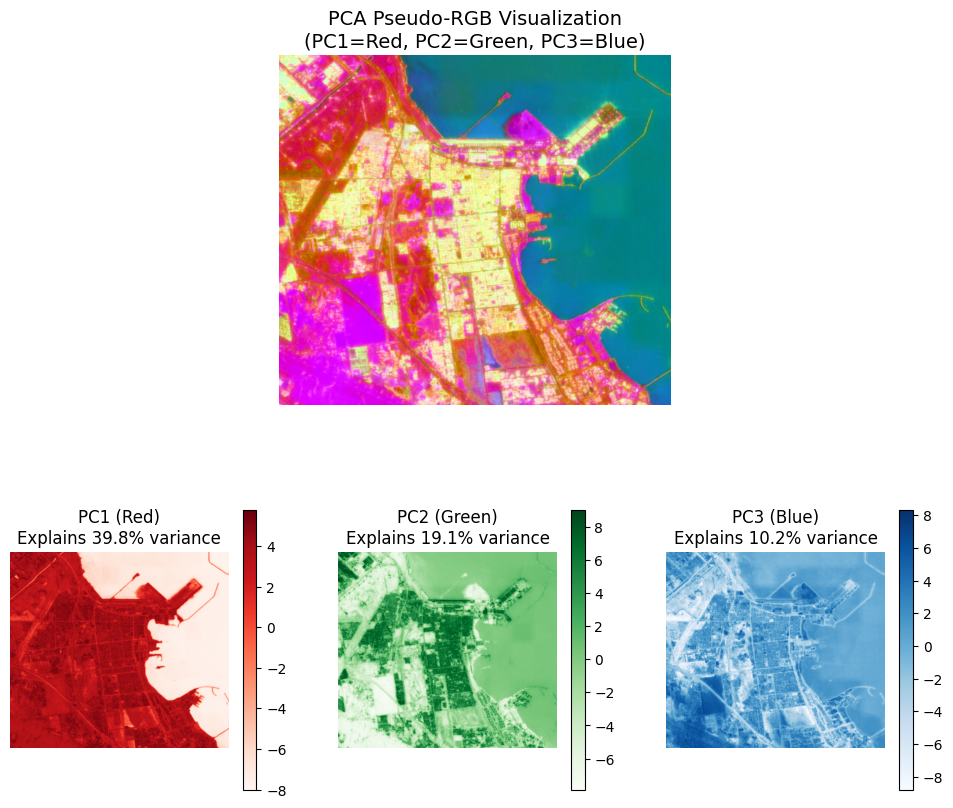

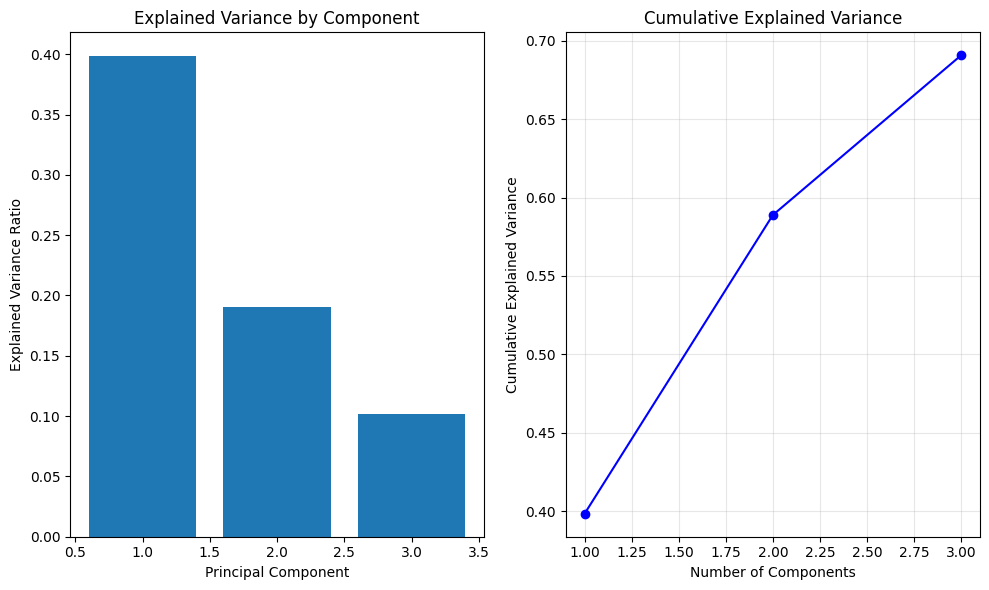

In [ ]:
# Colab: uncomment to install required packages
# !pip install rasterio scikit-learn matplotlib numpy

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import glob

# -----------------------------
# USER PARAMETERS
# -----------------------------
# Path to your downloaded GeoTIFF file
# Update this path to match your downloaded file
GEOTIFF_PATH = "/content/drive/MyDrive/EE_Embeddings_UAE/embedding_2017_region.tif"

# PCA and visualization settings
NORMALIZE_DATA = True          # Whether to standardize data before PCA
CONTRAST_STRETCH = True        # Apply contrast stretching to improve visualization
FIGSIZE = (12, 10)            # Figure size for plots

def load_embedding_data(file_path):
    """Load the 64-dimensional embedding data from GeoTIFF."""
    print(f"Loading embedding data from: {file_path}")

    with rasterio.open(file_path) as src:
        # Read all bands (should be 64 dimensions)
        data = src.read()  # Shape: (bands, height, width)
        profile = src.profile

    print(f"Data shape: {data.shape}")
    print(f"Number of bands (dimensions): {data.shape[0]}")
    print(f"Spatial dimensions: {data.shape[1]} x {data.shape[2]}")

    return data, profile

def reshape_for_pca(data):
    """Reshape spatial data for PCA processing."""
    bands, height, width = data.shape

    # Reshape to (pixels, bands) for PCA
    reshaped = data.reshape(bands, -1).T  # Shape: (height*width, bands)

    # Handle NaN/invalid values
    valid_mask = ~np.isnan(reshaped).any(axis=1)
    valid_data = reshaped[valid_mask]

    print(f"Original pixels: {height * width}")
    print(f"Valid pixels (no NaN): {valid_data.shape[0]}")

    return reshaped, valid_mask, (height, width)

def apply_pca(data, n_components=3, normalize=True):
    """Apply PCA to reduce dimensionality."""
    print(f"\nApplying PCA to reduce {data.shape[1]} dimensions to {n_components}...")

    # Remove invalid pixels for PCA fitting
    valid_mask = ~np.isnan(data).any(axis=1)
    valid_data = data[valid_mask]

    if normalize:
        print("Standardizing data...")
        scaler = StandardScaler()
        valid_data_scaled = scaler.fit_transform(valid_data)
    else:
        valid_data_scaled = valid_data
        scaler = None

    # Fit PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(valid_data_scaled)

    # Transform all data (including invalid pixels)
    if normalize and scaler is not None:
        data_scaled = scaler.transform(np.nan_to_num(data, nan=0))
    else:
        data_scaled = np.nan_to_num(data, nan=0)

    full_pca_result = pca.transform(data_scaled)

    # Restore NaN values where original data was invalid
    full_pca_result[~valid_mask] = np.nan

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

    return full_pca_result, pca

def contrast_stretch(data, percentiles=(2, 98)):
    """Apply percentile-based contrast stretching."""
    stretched = np.zeros_like(data)

    for i in range(data.shape[1]):
        band = data[:, i]
        valid_values = band[~np.isnan(band)]

        if len(valid_values) > 0:
            p_low, p_high = np.percentile(valid_values, percentiles)
            band_stretched = np.clip((band - p_low) / (p_high - p_low), 0, 1)
            stretched[:, i] = band_stretched
        else:
            stretched[:, i] = band

    return stretched

def create_rgb_image(pca_data, spatial_shape, contrast_stretch_flag=True):
    """Convert PCA components to RGB image."""
    height, width = spatial_shape

    # Reshape back to spatial dimensions
    rgb_data = pca_data.reshape(height, width, 3)

    if contrast_stretch_flag:
        print("Applying contrast stretching...")
        # Flatten for contrast stretching
        flat_data = rgb_data.reshape(-1, 3)
        stretched = contrast_stretch(flat_data)
        rgb_data = stretched.reshape(height, width, 3)
    else:
        # Simple min-max normalization
        for i in range(3):
            channel = rgb_data[:, :, i]
            valid_mask = ~np.isnan(channel)
            if valid_mask.any():
                channel_min = np.nanmin(channel)
                channel_max = np.nanmax(channel)
                rgb_data[:, :, i] = (channel - channel_min) / (channel_max - channel_min)

    # Handle any remaining NaN values
    rgb_data = np.nan_to_num(rgb_data, nan=0)

    return rgb_data

def plot_visualization(rgb_image, pca_components, pca_obj):
    """Create comprehensive visualization plots."""
    fig = plt.figure(figsize=FIGSIZE)

    # Main RGB visualization
    ax1 = plt.subplot(2, 2, (1, 2))
    plt.imshow(rgb_image)
    plt.title('PCA Pseudo-RGB Visualization\n(PC1=Red, PC2=Green, PC3=Blue)', fontsize=14)
    plt.axis('off')

    # Individual components
    ax2 = plt.subplot(2, 3, 4)
    pc1 = pca_components.reshape(rgb_image.shape[0], rgb_image.shape[1], 3)[:, :, 0]
    plt.imshow(pc1, cmap='Reds')
    plt.title(f'PC1 (Red)\nExplains {pca_obj.explained_variance_ratio_[0]:.1%} variance')
    plt.axis('off')
    plt.colorbar(shrink=0.8)

    ax3 = plt.subplot(2, 3, 5)
    pc2 = pca_components.reshape(rgb_image.shape[0], rgb_image.shape[1], 3)[:, :, 1]
    plt.imshow(pc2, cmap='Greens')
    plt.title(f'PC2 (Green)\nExplains {pca_obj.explained_variance_ratio_[1]:.1%} variance')
    plt.axis('off')
    plt.colorbar(shrink=0.8)

    ax4 = plt.subplot(2, 3, 6)
    pc3 = pca_components.reshape(rgb_image.shape[0], rgb_image.shape[1], 3)[:, :, 2]
    plt.imshow(pc3, cmap='Blues')
    plt.title(f'PC3 (Blue)\nExplains {pca_obj.explained_variance_ratio_[2]:.1%} variance')
    plt.axis('off')
    plt.colorbar(shrink=0.8)

    plt.tight_layout()
    plt.show()

    # Plot explained variance
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(pca_obj.explained_variance_ratio_) + 1),
            pca_obj.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')

    plt.subplot(1, 2, 2)
    cumsum = np.cumsum(pca_obj.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    """Main processing pipeline."""
    # Check if file exists
    if not os.path.exists(GEOTIFF_PATH):
        print(f"❌ File not found: {GEOTIFF_PATH}")
        print("\nLooking for GeoTIFF files in common locations...")

        # Search for potential files
        search_patterns = [
            "/content/drive/MyDrive/EE_Embeddings/*.tif",
            "/content/drive/MyDrive/EE_Embeddings/*.tiff",
            "/content/*.tif",
            "/content/*.tiff"
        ]

        found_files = []
        for pattern in search_patterns:
            found_files.extend(glob.glob(pattern))

        if found_files:
            print("Found these GeoTIFF files:")
            for i, file in enumerate(found_files):
                print(f"  {i+1}. {file}")
            print(f"\nUpdate GEOTIFF_PATH variable to use one of these files.")
        else:
            print("No GeoTIFF files found. Make sure you've downloaded the embedding data first.")
        return

    try:
        # Load data
        data, profile = load_embedding_data(GEOTIFF_PATH)

        # Prepare data for PCA
        reshaped_data, valid_mask, spatial_shape = reshape_for_pca(data)

        # Apply PCA
        pca_result, pca_obj = apply_pca(reshaped_data,
                                      n_components=3,
                                      normalize=NORMALIZE_DATA)

        # Create RGB image
        rgb_image = create_rgb_image(pca_result, spatial_shape, CONTRAST_STRETCH)

        print(f"\n✅ Successfully created PCA visualization!")
        print(f"RGB image shape: {rgb_image.shape}")
        print(f"Total variance explained by 3 components: {pca_obj.explained_variance_ratio_.sum():.1%}")

        # Create visualizations
        plot_visualization(rgb_image, pca_result, pca_obj)

    except Exception as e:
        print(f"❌ Error during processing: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    print("🎨 Earth Engine Embedding PCA Visualization")
    print("=" * 50)
    main()

In [ ]:
# Colab: uncomment to install
# !pip install earthengine-api pyproj tqdm

import ee
from pyproj import Geod
import math
import time
from tqdm import tqdm
import itertools
import sys

# -----------------------------
# USER PARAMETERS (EDIT IF NEEDED)
# -----------------------------
CENTER_LAT = 27.00000
CENTER_LON = 49.65444
REGION_SIZE_KM = 10.0          # Square region size (10 km x 10 km)
YEAR_LABEL = '2024'
START_DATE = '2024-01-01'
END_DATE = '2025-01-01'
EXPORT_TO_DRIVE = True
EXPORT_FOLDER = 'EE_Embeddings_UAE'   # Drive folder (created automatically if doesn't exist)
SCALE_METERS = 10
MAXPIXELS = 1e13
POLL_INTERVAL = 8                # seconds between status polls
EE_PROJECT = 'alpha-earth-473414'  # Replace with your GCP project ID

# Authenticate and initialize
ee.Authenticate()
ee.Initialize(project=EE_PROJECT)

# -----------------------------
# Geodesic helpers (pyproj.Geod)
# -----------------------------
geod = Geod(ellps="WGS84")

def destination_point(lat, lon, bearing_deg, distance_m):
    """
    Return (lat, lon) of point at distance_m and bearing_deg from (lat, lon).
    """
    lon2, lat2, backaz = geod.fwd(lon, lat, bearing_deg, distance_m)
    return lat2, lon2

# -----------------------------
# Compute region polygon coordinates
# -----------------------------
center_lat = CENTER_LAT
center_lon = CENTER_LON
half_size_m = (REGION_SIZE_KM / 2.0) * 1000.0  # 5 km in meters
corner_dist = half_size_m * math.sqrt(2.0)     # distance from center to corner

# Calculate corner coordinates: NW(315), NE(45), SE(135), SW(225)
nw_lat, nw_lon = destination_point(center_lat, center_lon, 315.0, corner_dist)
ne_lat, ne_lon = destination_point(center_lat, center_lon, 45.0, corner_dist)
se_lat, se_lon = destination_point(center_lat, center_lon, 135.0, corner_dist)
sw_lat, sw_lon = destination_point(center_lat, center_lon, 225.0, corner_dist)

# Create polygon coordinates (closed ring)
polygon_coords = [
    [nw_lon, nw_lat],
    [ne_lon, ne_lat],
    [se_lon, se_lat],
    [sw_lon, sw_lat],
    [nw_lon, nw_lat]
]

print(f"Region center: {center_lat:.6f}, {center_lon:.6f}")
print(f"Region size: {REGION_SIZE_KM} km x {REGION_SIZE_KM} km")

# -----------------------------
# Prepare collection and export
# -----------------------------
dataset_id = 'GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL'
collection = ee.ImageCollection(dataset_id)

def make_export_task(img, year_label):
    file_basename = f"embedding_{year_label}_region"
    description = f"{file_basename}_{int(time.time())}"

    if EXPORT_TO_DRIVE:
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=description,
            folder=EXPORT_FOLDER,
            fileNamePrefix=file_basename,
            region=polygon_coords,
            scale=SCALE_METERS,
            crs='EPSG:4326',
            maxPixels=MAXPIXELS
        )
    else:
        # Change bucket name if you prefer GCS
        task = ee.batch.Export.image.toCloudStorage(
            image=img,
            description=description,
            bucket='your-bucket-name',
            fileNamePrefix=file_basename,
            region=polygon_coords,
            scale=SCALE_METERS,
            crs='EPSG:4326',
            maxPixels=MAXPIXELS
        )
    return task, file_basename

# Create region geometry
region_geom = ee.Geometry.Polygon(polygon_coords)

# Filter collection for the specified year and region
filtered_collection = collection.filterDate(START_DATE, END_DATE).filterBounds(region_geom)
img = filtered_collection.first()

if img is None:
    # Fallback: try using mean of all images in the collection
    try:
        img = filtered_collection.mean()
        print("[INFO] Using mean() mosaic (no single image returned by first()).")
    except Exception as e:
        print(f"[ERROR] No image available for the region in {YEAR_LABEL}. Error: {str(e)}")
        sys.exit(1)

# Start export task
task, basename = make_export_task(img, YEAR_LABEL)
task.start()
print(f"Started export task: {basename}")
print(f"Earth Engine task ID: {task.id}")

# -----------------------------
# Poll task status with progress bar
# -----------------------------
print(f"\nExporting {REGION_SIZE_KM}km x {REGION_SIZE_KM}km region to Google Drive folder: {EXPORT_FOLDER}")
print("Polling task status...")

spinner = itertools.cycle(['|', '/', '-', '\\'])
task_complete = False

try:
    with tqdm(total=100, desc="Export progress", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}% ") as pbar:
        last_progress = 0

        while not task_complete:
            try:
                status = task.status()
                state = status.get('state', 'UNKNOWN')
                progress = status.get('progress')

                # Handle progress display
                if progress is not None:
                    try:
                        if isinstance(progress, (int, float)):
                            val = float(progress)
                            if val <= 1.0:
                                current_progress = int(val * 100)
                            else:
                                current_progress = int(val)
                        else:
                            current_progress = last_progress
                    except:
                        current_progress = last_progress
                else:
                    # No numeric progress, increment slowly for visual feedback
                    current_progress = min(last_progress + 1, 95)

                # Update progress bar
                if current_progress > last_progress:
                    pbar.update(current_progress - last_progress)
                    last_progress = current_progress

                # Print status update
                if progress is not None:
                    print(f"\rTask state: {state} - Progress: {current_progress}%", end='')
                else:
                    print(f"\rTask state: {state} - {next(spinner)}", end='')

                # Check if task is complete
                if state in ('COMPLETED', 'FAILED', 'CANCELLED'):
                    task_complete = True
                    if state == 'COMPLETED' and last_progress < 100:
                        pbar.update(100 - last_progress)
                    break

            except Exception as e:
                print(f"\nError checking task status: {str(e)}")
                break

            time.sleep(POLL_INTERVAL)

except KeyboardInterrupt:
    print("\nPolling interrupted by user. Task is still running server-side in Earth Engine.")

# Final status
print(f"\n\nFinal task status:")
try:
    final_status = task.status()
    state = final_status.get('state', 'UNKNOWN')
    print(f"Task: {basename}")
    print(f"State: {state}")

    if state == 'COMPLETED':
        print(f"✅ Export completed successfully!")
        print(f"Check your Google Drive folder: {EXPORT_FOLDER}")
    elif state == 'FAILED':
        error_msg = final_status.get('error_message', 'No error message available')
        print(f"❌ Export failed: {error_msg}")
    elif state == 'CANCELLED':
        print(f"⚠️  Export was cancelled")
    else:
        print(f"Task is still in state: {state}")

except Exception as e:
    print(f"Could not get final status: {str(e)}")

print(f"\nRegion exported:")
print(f"- Center: {center_lat:.6f}, {center_lon:.6f}")
print(f"- Size: {REGION_SIZE_KM} km x {REGION_SIZE_KM} km")
print(f"- Year: {YEAR_LABEL}")
print(f"- Scale: {SCALE_METERS} meters per pixel")

Region center: 27.000000, 49.654440
Region size: 10.0 km x 10.0 km
Started export task: embedding_2024_region
Earth Engine task ID: 4GF4AXFCLHY4Z52WNBARNHVZ

Exporting 10.0km x 10.0km region to Google Drive folder: EE_Embeddings_UAE
Polling task status...


Export progress:   1%|          | 1/100% 

Task state: READY - |

Export progress:   2%|▏         | 2/100% 

Task state: READY - /

Export progress:   3%|▎         | 3/100% 

Task state: RUNNING - -

Export progress:   4%|▍         | 4/100% 

Task state: RUNNING - \

Export progress:   5%|▌         | 5/100% 

Task state: RUNNING - |

Export progress:   6%|▌         | 6/100% 

Task state: RUNNING - /

Export progress:   7%|▋         | 7/100% 

Task state: RUNNING - -

Export progress:   8%|▊         | 8/100% 

Task state: RUNNING - \

Export progress:   9%|▉         | 9/100% 

Task state: RUNNING - |

Export progress:  10%|█         | 10/100% 

Task state: RUNNING - /

Export progress:  11%|█         | 11/100% 

Task state: RUNNING - -

Export progress:  12%|█▏        | 12/100% 

Task state: RUNNING - \

Export progress:  13%|█▎        | 13/100% 

Task state: RUNNING - |

Export progress:  14%|█▍        | 14/100% 

Task state: RUNNING - /

Export progress:  15%|█▌        | 15/100% 

Task state: RUNNING - -

Export progress:  16%|█▌        | 16/100% 

Task state: RUNNING - \

Export progress:  17%|█▋        | 17/100% 

Task state: RUNNING - |

Export progress:  18%|█▊        | 18/100% 

Task state: RUNNING - /

Export progress:  19%|█▉        | 19/100% 

Task state: RUNNING - -

Export progress:  20%|██        | 20/100% 

Task state: RUNNING - \

Export progress:  21%|██        | 21/100% 

Task state: RUNNING - |

Export progress:  22%|██▏       | 22/100% 

Task state: RUNNING - /

Export progress:  23%|██▎       | 23/100% 

Task state: RUNNING - -

Export progress:  24%|██▍       | 24/100% 

Task state: RUNNING - \

Export progress:  25%|██▌       | 25/100% 

Task state: RUNNING - |

Export progress:  26%|██▌       | 26/100% 

Task state: RUNNING - /

Export progress:  27%|██▋       | 27/100% 

Task state: RUNNING - -

Export progress:  28%|██▊       | 28/100% 

Task state: RUNNING - \

Export progress:  29%|██▉       | 29/100% 

Task state: RUNNING - |

Export progress:  30%|███       | 30/100% 

Task state: RUNNING - /

Export progress:  31%|███       | 31/100% 

Task state: RUNNING - -

Export progress:  32%|███▏      | 32/100% 

Task state: RUNNING - \

Export progress:  33%|███▎      | 33/100% 

Task state: RUNNING - |

Export progress:  34%|███▍      | 34/100% 

Task state: RUNNING - /

Export progress:  35%|███▌      | 35/100% 

Task state: RUNNING - -

Export progress:  36%|███▌      | 36/100% 

Task state: RUNNING - \

Export progress:  37%|███▋      | 37/100% 

Task state: RUNNING - |

Export progress:  38%|███▊      | 38/100% 

Task state: RUNNING - /

Export progress:  39%|███▉      | 39/100% 

Task state: RUNNING - -

Export progress:  40%|████      | 40/100% 

Task state: RUNNING - \

Export progress:  41%|████      | 41/100% 

Task state: RUNNING - |

Export progress:  42%|████▏     | 42/100% 

Task state: RUNNING - /

Export progress:  43%|████▎     | 43/100% 

Task state: RUNNING - -

Export progress:  44%|████▍     | 44/100% 

Task state: RUNNING - \

Export progress:  45%|████▌     | 45/100% 

Task state: RUNNING - |

Export progress:  46%|████▌     | 46/100% 

Task state: RUNNING - /

Export progress:  47%|████▋     | 47/100% 

Task state: RUNNING - -

Export progress:  48%|████▊     | 48/100% 

Task state: RUNNING - \

Export progress:  49%|████▉     | 49/100% 

Task state: RUNNING - |

Export progress:  50%|█████     | 50/100% 

Task state: RUNNING - /

Export progress:  51%|█████     | 51/100% 

Task state: RUNNING - -

Export progress:  52%|█████▏    | 52/100% 

Task state: RUNNING - \

Export progress:  53%|█████▎    | 53/100% 

Task state: RUNNING - |

Export progress:  54%|█████▍    | 54/100% 

Task state: RUNNING - /

Export progress:  55%|█████▌    | 55/100% 

Task state: RUNNING - -

Export progress:  56%|█████▌    | 56/100% 

Task state: RUNNING - \

Export progress:  57%|█████▋    | 57/100% 

Task state: RUNNING - |

Export progress:  58%|█████▊    | 58/100% 

Task state: RUNNING - /

Export progress:  59%|█████▉    | 59/100% 

Task state: RUNNING - -

Export progress:  60%|██████    | 60/100% 

Task state: RUNNING - \

Export progress:  61%|██████    | 61/100% 

Task state: RUNNING - |

Export progress:  62%|██████▏   | 62/100% 

Task state: RUNNING - /

Export progress:  63%|██████▎   | 63/100% 

Task state: RUNNING - -

Export progress:  64%|██████▍   | 64/100% 

Task state: RUNNING - \

Export progress:  65%|██████▌   | 65/100% 

Task state: RUNNING - |

Export progress:  66%|██████▌   | 66/100% 

Task state: RUNNING - /

Export progress:  67%|██████▋   | 67/100% 

Task state: RUNNING - -

Export progress:  68%|██████▊   | 68/100% 

Task state: RUNNING - \

Export progress:  69%|██████▉   | 69/100% 

Task state: RUNNING - |

Export progress:  70%|███████   | 70/100% 

Task state: RUNNING - /

Export progress:  71%|███████   | 71/100% 

Task state: RUNNING - -

Export progress:  72%|███████▏  | 72/100% 

Task state: RUNNING - \

Export progress:  73%|███████▎  | 73/100% 

Task state: RUNNING - |

Export progress:  74%|███████▍  | 74/100% 

Task state: RUNNING - /

Export progress:  75%|███████▌  | 75/100% 

Task state: RUNNING - -

Export progress:  76%|███████▌  | 76/100% 

Task state: RUNNING - \

Export progress:  77%|███████▋  | 77/100% 

Task state: RUNNING - |

Export progress:  78%|███████▊  | 78/100% 

Task state: RUNNING - /

Export progress:  79%|███████▉  | 79/100% 

Task state: RUNNING - -

Export progress:  80%|████████  | 80/100% 

Task state: RUNNING - \

Export progress:  81%|████████  | 81/100% 

Task state: RUNNING - |

Export progress:  82%|████████▏ | 82/100% 

Task state: RUNNING - /

Export progress:  83%|████████▎ | 83/100% 

Task state: RUNNING - -

Export progress:  84%|████████▍ | 84/100% 

Task state: RUNNING - \

Export progress:  85%|████████▌ | 85/100% 

Task state: RUNNING - |

Export progress:  86%|████████▌ | 86/100% 

Task state: RUNNING - /

Export progress:  87%|████████▋ | 87/100% 

Task state: RUNNING - -

Export progress:  88%|████████▊ | 88/100% 

Task state: RUNNING - \

Export progress: 100%|██████████| 100/100% 


Task state: COMPLETED - |

Final task status:
Task: embedding_2024_region
State: COMPLETED
✅ Export completed successfully!
Check your Google Drive folder: EE_Embeddings_UAE

Region exported:
- Center: 27.000000, 49.654440
- Size: 10.0 km x 10.0 km
- Year: 2024
- Scale: 10 meters per pixel


🎨 Earth Engine Embedding PCA Visualization
Loading embedding data from: /content/drive/MyDrive/EE_Embeddings_UAE/embedding_2024_region.tif
Data shape: (64, 1005, 1123)
Number of bands (dimensions): 64
Spatial dimensions: 1005 x 1123
Original pixels: 1128615
Valid pixels (no NaN): 1128615

Applying PCA to reduce 64 dimensions to 3...
Standardizing data...
PCA explained variance ratio: [0.38476958 0.19465706 0.09292506]
Total variance explained: 0.672
Applying contrast stretching...

✅ Successfully created PCA visualization!
RGB image shape: (1005, 1123, 3)
Total variance explained by 3 components: 67.2%


/tmp/ipython-input-2821030522.py:168: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


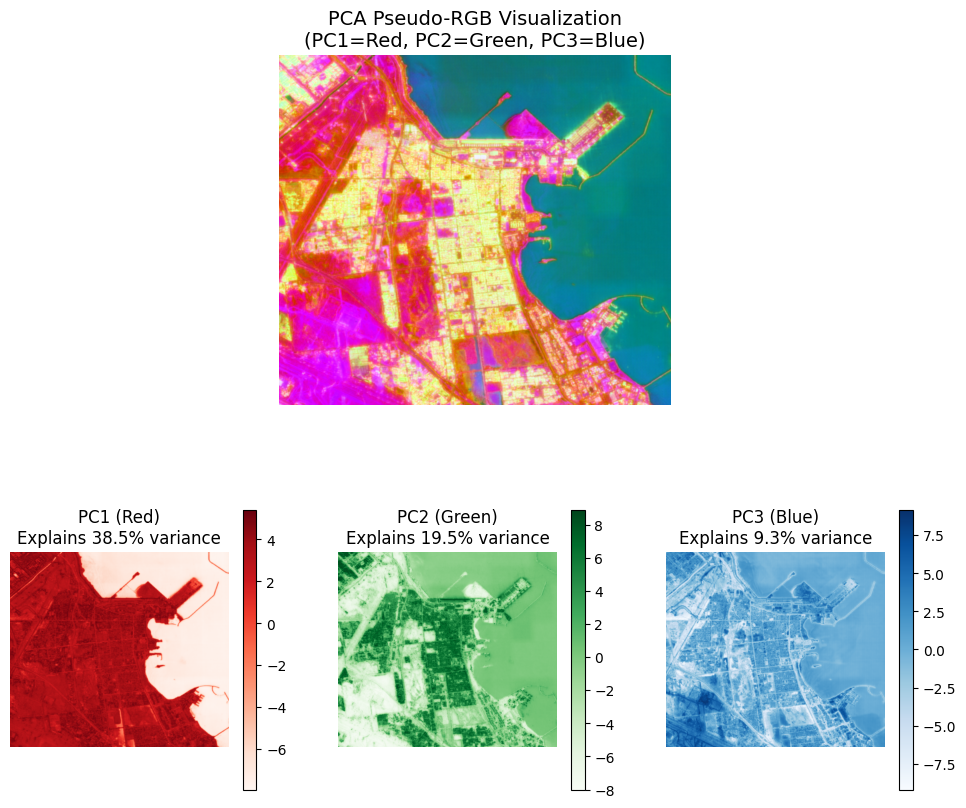

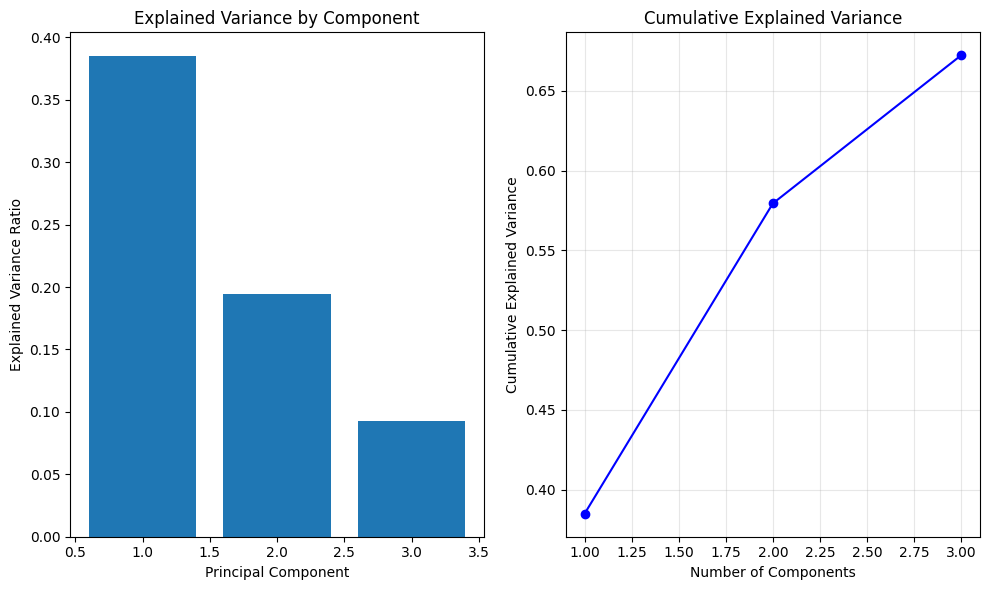

In [ ]:
# Colab: uncomment to install required packages
# !pip install rasterio scikit-learn matplotlib numpy

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import glob

# -----------------------------
# USER PARAMETERS
# -----------------------------
# Path to your downloaded GeoTIFF file
# Update this path to match your downloaded file
GEOTIFF_PATH = "/content/drive/MyDrive/EE_Embeddings_UAE/embedding_2024_region.tif"

# PCA and visualization settings
NORMALIZE_DATA = True          # Whether to standardize data before PCA
CONTRAST_STRETCH = True        # Apply contrast stretching to improve visualization
FIGSIZE = (12, 10)            # Figure size for plots

def load_embedding_data(file_path):
    """Load the 64-dimensional embedding data from GeoTIFF."""
    print(f"Loading embedding data from: {file_path}")

    with rasterio.open(file_path) as src:
        # Read all bands (should be 64 dimensions)
        data = src.read()  # Shape: (bands, height, width)
        profile = src.profile

    print(f"Data shape: {data.shape}")
    print(f"Number of bands (dimensions): {data.shape[0]}")
    print(f"Spatial dimensions: {data.shape[1]} x {data.shape[2]}")

    return data, profile

def reshape_for_pca(data):
    """Reshape spatial data for PCA processing."""
    bands, height, width = data.shape

    # Reshape to (pixels, bands) for PCA
    reshaped = data.reshape(bands, -1).T  # Shape: (height*width, bands)

    # Handle NaN/invalid values
    valid_mask = ~np.isnan(reshaped).any(axis=1)
    valid_data = reshaped[valid_mask]

    print(f"Original pixels: {height * width}")
    print(f"Valid pixels (no NaN): {valid_data.shape[0]}")

    return reshaped, valid_mask, (height, width)

def apply_pca(data, n_components=3, normalize=True):
    """Apply PCA to reduce dimensionality."""
    print(f"\nApplying PCA to reduce {data.shape[1]} dimensions to {n_components}...")

    # Remove invalid pixels for PCA fitting
    valid_mask = ~np.isnan(data).any(axis=1)
    valid_data = data[valid_mask]

    if normalize:
        print("Standardizing data...")
        scaler = StandardScaler()
        valid_data_scaled = scaler.fit_transform(valid_data)
    else:
        valid_data_scaled = valid_data
        scaler = None

    # Fit PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(valid_data_scaled)

    # Transform all data (including invalid pixels)
    if normalize and scaler is not None:
        data_scaled = scaler.transform(np.nan_to_num(data, nan=0))
    else:
        data_scaled = np.nan_to_num(data, nan=0)

    full_pca_result = pca.transform(data_scaled)

    # Restore NaN values where original data was invalid
    full_pca_result[~valid_mask] = np.nan

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

    return full_pca_result, pca

def contrast_stretch(data, percentiles=(2, 98)):
    """Apply percentile-based contrast stretching."""
    stretched = np.zeros_like(data)

    for i in range(data.shape[1]):
        band = data[:, i]
        valid_values = band[~np.isnan(band)]

        if len(valid_values) > 0:
            p_low, p_high = np.percentile(valid_values, percentiles)
            band_stretched = np.clip((band - p_low) / (p_high - p_low), 0, 1)
            stretched[:, i] = band_stretched
        else:
            stretched[:, i] = band

    return stretched

def create_rgb_image(pca_data, spatial_shape, contrast_stretch_flag=True):
    """Convert PCA components to RGB image."""
    height, width = spatial_shape

    # Reshape back to spatial dimensions
    rgb_data = pca_data.reshape(height, width, 3)

    if contrast_stretch_flag:
        print("Applying contrast stretching...")
        # Flatten for contrast stretching
        flat_data = rgb_data.reshape(-1, 3)
        stretched = contrast_stretch(flat_data)
        rgb_data = stretched.reshape(height, width, 3)
    else:
        # Simple min-max normalization
        for i in range(3):
            channel = rgb_data[:, :, i]
            valid_mask = ~np.isnan(channel)
            if valid_mask.any():
                channel_min = np.nanmin(channel)
                channel_max = np.nanmax(channel)
                rgb_data[:, :, i] = (channel - channel_min) / (channel_max - channel_min)

    # Handle any remaining NaN values
    rgb_data = np.nan_to_num(rgb_data, nan=0)

    return rgb_data

def plot_visualization(rgb_image, pca_components, pca_obj):
    """Create comprehensive visualization plots."""
    fig = plt.figure(figsize=FIGSIZE)

    # Main RGB visualization
    ax1 = plt.subplot(2, 2, (1, 2))
    plt.imshow(rgb_image)
    plt.title('PCA Pseudo-RGB Visualization\n(PC1=Red, PC2=Green, PC3=Blue)', fontsize=14)
    plt.axis('off')

    # Individual components
    ax2 = plt.subplot(2, 3, 4)
    pc1 = pca_components.reshape(rgb_image.shape[0], rgb_image.shape[1], 3)[:, :, 0]
    plt.imshow(pc1, cmap='Reds')
    plt.title(f'PC1 (Red)\nExplains {pca_obj.explained_variance_ratio_[0]:.1%} variance')
    plt.axis('off')
    plt.colorbar(shrink=0.8)

    ax3 = plt.subplot(2, 3, 5)
    pc2 = pca_components.reshape(rgb_image.shape[0], rgb_image.shape[1], 3)[:, :, 1]
    plt.imshow(pc2, cmap='Greens')
    plt.title(f'PC2 (Green)\nExplains {pca_obj.explained_variance_ratio_[1]:.1%} variance')
    plt.axis('off')
    plt.colorbar(shrink=0.8)

    ax4 = plt.subplot(2, 3, 6)
    pc3 = pca_components.reshape(rgb_image.shape[0], rgb_image.shape[1], 3)[:, :, 2]
    plt.imshow(pc3, cmap='Blues')
    plt.title(f'PC3 (Blue)\nExplains {pca_obj.explained_variance_ratio_[2]:.1%} variance')
    plt.axis('off')
    plt.colorbar(shrink=0.8)

    plt.tight_layout()
    plt.show()

    # Plot explained variance
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(pca_obj.explained_variance_ratio_) + 1),
            pca_obj.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')

    plt.subplot(1, 2, 2)
    cumsum = np.cumsum(pca_obj.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    """Main processing pipeline."""
    # Check if file exists
    if not os.path.exists(GEOTIFF_PATH):
        print(f"❌ File not found: {GEOTIFF_PATH}")
        print("\nLooking for GeoTIFF files in common locations...")

        # Search for potential files
        search_patterns = [
            "/content/drive/MyDrive/EE_Embeddings/*.tif",
            "/content/drive/MyDrive/EE_Embeddings/*.tiff",
            "/content/*.tif",
            "/content/*.tiff"
        ]

        found_files = []
        for pattern in search_patterns:
            found_files.extend(glob.glob(pattern))

        if found_files:
            print("Found these GeoTIFF files:")
            for i, file in enumerate(found_files):
                print(f"  {i+1}. {file}")
            print(f"\nUpdate GEOTIFF_PATH variable to use one of these files.")
        else:
            print("No GeoTIFF files found. Make sure you've downloaded the embedding data first.")
        return

    try:
        # Load data
        data, profile = load_embedding_data(GEOTIFF_PATH)

        # Prepare data for PCA
        reshaped_data, valid_mask, spatial_shape = reshape_for_pca(data)

        # Apply PCA
        pca_result, pca_obj = apply_pca(reshaped_data,
                                      n_components=3,
                                      normalize=NORMALIZE_DATA)

        # Create RGB image
        rgb_image = create_rgb_image(pca_result, spatial_shape, CONTRAST_STRETCH)

        print(f"\n✅ Successfully created PCA visualization!")
        print(f"RGB image shape: {rgb_image.shape}")
        print(f"Total variance explained by 3 components: {pca_obj.explained_variance_ratio_.sum():.1%}")

        # Create visualizations
        plot_visualization(rgb_image, pca_result, pca_obj)

    except Exception as e:
        print(f"❌ Error during processing: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    print("🎨 Earth Engine Embedding PCA Visualization")
    print("=" * 50)
    main()

In [ ]:
# Colab: uncomment to install required packages
# !pip install rasterio scikit-learn matplotlib numpy scipy seaborn

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import ndimage
from scipy.spatial.distance import euclidean
import seaborn as sns
import os

# -----------------------------
# USER PARAMETERS
# -----------------------------
GEOTIFF_2017 = "/content/drive/MyDrive/EE_Embeddings_UAE/embedding_2017_region.tif"
GEOTIFF_2024 = "/content/drive/MyDrive/EE_Embeddings_UAE/embedding_2024_region.tif"

# Analysis settings
NORMALIZE_DATA = True
CONTRAST_STRETCH = True
CHANGE_THRESHOLD_PERCENTILE = 90  # Top X% of changes marked as hotspots
N_CLUSTERS = 5  # Number of land cover clusters
HOTSPOT_MIN_SIZE = 10  # Minimum pixels for hotspot detection
FIGSIZE = (20, 12)

def load_embedding_data(file_path):
    """Load embedding data from GeoTIFF."""
    print(f"Loading: {file_path}")
    with rasterio.open(file_path) as src:
        data = src.read()
        profile = src.profile
    print(f"  Shape: {data.shape} (bands: {data.shape[0]})")
    return data, profile

def prepare_data_for_analysis(data):
    """Reshape and clean data."""
    bands, height, width = data.shape
    reshaped = data.reshape(bands, -1).T
    valid_mask = ~np.isnan(reshaped).any(axis=1)
    return reshaped, valid_mask, (height, width)

def compute_embedding_distance(emb1, emb2):
    """Compute pixel-wise Euclidean distance between embeddings."""
    # Handle NaN values
    emb1_clean = np.nan_to_num(emb1, nan=0)
    emb2_clean = np.nan_to_num(emb2, nan=0)

    # Compute Euclidean distance for each pixel
    distances = np.sqrt(np.sum((emb1_clean - emb2_clean) ** 2, axis=1))

    return distances

def detect_hotspots(change_map, threshold_percentile, min_size):
    """Detect and label significant change hotspots."""
    # Threshold based on percentile
    valid_changes = change_map[~np.isnan(change_map)]
    if len(valid_changes) == 0:
        return np.zeros_like(change_map), []

    threshold = np.percentile(valid_changes, threshold_percentile)
    binary_map = change_map > threshold

    # Remove small regions
    cleaned = ndimage.binary_opening(binary_map, structure=np.ones((3, 3)))

    # Label connected components
    labeled_array, num_features = ndimage.label(cleaned)

    # Filter by size
    hotspots = []
    filtered_labels = np.zeros_like(labeled_array)

    for i in range(1, num_features + 1):
        region = labeled_array == i
        size = np.sum(region)
        if size >= min_size:
            filtered_labels[region] = len(hotspots) + 1

            # Get region properties
            coords = np.argwhere(region)
            center = coords.mean(axis=0)
            max_change = change_map[region].max()
            mean_change = change_map[region].mean()

            hotspots.append({
                'id': len(hotspots) + 1,
                'size': size,
                'center': center,
                'max_change': max_change,
                'mean_change': mean_change
            })

    return filtered_labels, hotspots

def apply_pca_comparison(data1, data2, n_components=3):
    """Apply PCA to both datasets using shared transformation."""
    print("\nApplying PCA for visualization...")

    # Combine data for consistent PCA
    valid_mask1 = ~np.isnan(data1).any(axis=1)
    valid_mask2 = ~np.isnan(data2).any(axis=1)
    combined_valid = valid_mask1 & valid_mask2

    combined_data = np.vstack([
        data1[combined_valid],
        data2[combined_valid]
    ])

    if NORMALIZE_DATA:
        scaler = StandardScaler()
        combined_scaled = scaler.fit_transform(combined_data)
    else:
        combined_scaled = combined_data
        scaler = None

    pca = PCA(n_components=n_components)
    pca.fit(combined_scaled)

    # Transform each dataset
    def transform_data(data, valid_mask):
        if NORMALIZE_DATA and scaler:
            data_scaled = scaler.transform(np.nan_to_num(data, nan=0))
        else:
            data_scaled = np.nan_to_num(data, nan=0)

        result = pca.transform(data_scaled)
        result[~valid_mask] = np.nan
        return result

    pca1 = transform_data(data1, valid_mask1)
    pca2 = transform_data(data2, valid_mask2)

    print(f"  Explained variance: {pca.explained_variance_ratio_.sum():.1%}")

    return pca1, pca2, pca

def create_rgb_visualization(pca_data, spatial_shape):
    """Convert PCA to RGB with contrast stretching."""
    height, width = spatial_shape
    rgb = pca_data.reshape(height, width, 3)

    if CONTRAST_STRETCH:
        for i in range(3):
            channel = rgb[:, :, i]
            valid = ~np.isnan(channel)
            if valid.any():
                p2, p98 = np.percentile(channel[valid], [2, 98])
                rgb[:, :, i] = np.clip((channel - p2) / (p98 - p2), 0, 1)

    return np.nan_to_num(rgb, nan=0)

def cluster_analysis(data1, data2, spatial_shape, n_clusters):
    """Perform clustering to identify land cover types and changes."""
    print(f"\nPerforming clustering analysis ({n_clusters} clusters)...")

    # Prepare data
    valid_mask1 = ~np.isnan(data1).any(axis=1)
    valid_mask2 = ~np.isnan(data2).any(axis=1)
    combined_valid = valid_mask1 & valid_mask2

    # Cluster 2017 data
    kmeans1 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters1 = np.full(len(data1), -1)
    clusters1[combined_valid] = kmeans1.fit_predict(data1[combined_valid])

    # Cluster 2024 data
    kmeans2 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters2 = np.full(len(data2), -1)
    clusters2[combined_valid] = kmeans2.fit_predict(data2[combined_valid])

    # Reshape to spatial
    height, width = spatial_shape
    clusters1_map = clusters1.reshape(height, width)
    clusters2_map = clusters2.reshape(height, width)

    # Compute cluster transitions
    transition_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            mask = (clusters1_map == i) & (clusters2_map == j)
            transition_matrix[i, j] = np.sum(mask)

    return clusters1_map, clusters2_map, transition_matrix

def plot_comprehensive_analysis(data1, data2, spatial_shape, profile):
    """Create comprehensive visualization."""
    height, width = spatial_shape

    # 1. Compute change metrics
    print("\n" + "="*60)
    print("COMPUTING CHANGE METRICS")
    print("="*60)

    distances = compute_embedding_distance(data1, data2)
    change_map = distances.reshape(height, width)

    valid_changes = change_map[~np.isnan(change_map) & (change_map > 0)]
    print(f"Change statistics:")
    print(f"  Mean change: {valid_changes.mean():.4f}")
    print(f"  Std change: {valid_changes.std():.4f}")
    print(f"  Max change: {valid_changes.max():.4f}")
    print(f"  95th percentile: {np.percentile(valid_changes, 95):.4f}")

    # 2. Detect hotspots
    print(f"\nDetecting change hotspots (threshold: {CHANGE_THRESHOLD_PERCENTILE}th percentile)...")
    hotspot_map, hotspots = detect_hotspots(change_map, CHANGE_THRESHOLD_PERCENTILE, HOTSPOT_MIN_SIZE)
    print(f"  Found {len(hotspots)} significant change hotspots")

    # 3. PCA visualization
    pca1, pca2, pca_obj = apply_pca_comparison(data1, data2)
    rgb1 = create_rgb_visualization(pca1, spatial_shape)
    rgb2 = create_rgb_visualization(pca2, spatial_shape)

    # 4. Clustering
    clusters1, clusters2, transition_matrix = cluster_analysis(data1, data2, spatial_shape, N_CLUSTERS)

    # ============== VISUALIZATION ==============
    print("\nGenerating visualizations...")

    # Figure 1: Main comparison
    fig1 = plt.figure(figsize=FIGSIZE)

    # 2017 RGB
    ax1 = plt.subplot(2, 3, 1)
    plt.imshow(rgb1)
    plt.title('2017 - PCA Pseudo-RGB', fontsize=14, fontweight='bold')
    plt.axis('off')

    # 2024 RGB
    ax2 = plt.subplot(2, 3, 2)
    plt.imshow(rgb2)
    plt.title('2024 - PCA Pseudo-RGB', fontsize=14, fontweight='bold')
    plt.axis('off')

    # Change magnitude
    ax3 = plt.subplot(2, 3, 3)
    im = plt.imshow(change_map, cmap='hot', vmin=0, vmax=np.percentile(valid_changes, 99))
    plt.title('Change Magnitude\n(Embedding Distance)', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.colorbar(im, ax=ax3, shrink=0.8, label='Distance')

    # Hotspots
    ax4 = plt.subplot(2, 3, 4)
    plt.imshow(change_map, cmap='gray', alpha=0.5)
    hotspot_display = np.ma.masked_where(hotspot_map == 0, hotspot_map)
    plt.imshow(hotspot_display, cmap='Reds', alpha=0.7)
    plt.title(f'Change Hotspots\n({len(hotspots)} detected)', fontsize=14, fontweight='bold')
    plt.axis('off')

    # 2017 Clusters
    ax5 = plt.subplot(2, 3, 5)
    plt.imshow(clusters1, cmap='tab10', vmin=0, vmax=N_CLUSTERS-1)
    plt.title(f'2017 - Land Cover Clusters\n({N_CLUSTERS} classes)', fontsize=14, fontweight='bold')
    plt.axis('off')

    # 2024 Clusters
    ax6 = plt.subplot(2, 3, 6)
    plt.imshow(clusters2, cmap='tab10', vmin=0, vmax=N_CLUSTERS-1)
    plt.title(f'2024 - Land Cover Clusters\n({N_CLUSTERS} classes)', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('comparison_overview.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Figure 2: Change analysis
    fig2 = plt.figure(figsize=(18, 6))

    # Change histogram
    ax1 = plt.subplot(1, 3, 1)
    plt.hist(valid_changes, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
    threshold = np.percentile(valid_changes, CHANGE_THRESHOLD_PERCENTILE)
    plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'{CHANGE_THRESHOLD_PERCENTILE}th percentile')
    plt.xlabel('Change Magnitude', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Changes', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Transition matrix
    ax2 = plt.subplot(1, 3, 2)
    # Normalize by row
    transition_normalized = transition_matrix / (transition_matrix.sum(axis=1, keepdims=True) + 1e-10)
    sns.heatmap(transition_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
                square=True, cbar_kws={'label': 'Transition Probability'})
    plt.xlabel('2024 Cluster', fontsize=12)
    plt.ylabel('2017 Cluster', fontsize=12)
    plt.title('Cluster Transition Matrix', fontsize=14, fontweight='bold')

    # PCA variance
    ax3 = plt.subplot(1, 3, 3)
    components = np.arange(1, len(pca_obj.explained_variance_ratio_) + 1)
    plt.bar(components, pca_obj.explained_variance_ratio_, alpha=0.7, color='steelblue', edgecolor='black')
    plt.xlabel('Principal Component', fontsize=12)
    plt.ylabel('Explained Variance Ratio', fontsize=12)
    plt.title('PCA Explained Variance', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('change_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print hotspot details
    if len(hotspots) > 0:
        print("\n" + "="*60)
        print("TOP 10 CHANGE HOTSPOTS")
        print("="*60)
        sorted_hotspots = sorted(hotspots, key=lambda x: x['mean_change'], reverse=True)[:10]
        for hs in sorted_hotspots:
            print(f"\nHotspot {hs['id']}:")
            print(f"  Size: {hs['size']} pixels")
            print(f"  Center: ({hs['center'][0]:.1f}, {hs['center'][1]:.1f})")
            print(f"  Mean change: {hs['mean_change']:.4f}")
            print(f"  Max change: {hs['max_change']:.4f}")

    return change_map, hotspot_map, hotspots, clusters1, clusters2

def main():
    """Main analysis pipeline."""
    print("🌍 TEMPORAL EMBEDDING COMPARISON & CHANGE DETECTION")
    print("="*60)

    # Check files exist
    if not os.path.exists(GEOTIFF_2017):
        print(f"❌ 2017 file not found: {GEOTIFF_2017}")
        return
    if not os.path.exists(GEOTIFF_2024):
        print(f"❌ 2024 file not found: {GEOTIFF_2024}")
        return

    try:
        # Load data
        print("\nLOADING DATA...")
        data1, profile1 = load_embedding_data(GEOTIFF_2017)
        data2, profile2 = load_embedding_data(GEOTIFF_2024)

        # Verify compatibility
        if data1.shape != data2.shape:
            print(f"⚠️  Warning: Shape mismatch! 2017: {data1.shape}, 2024: {data2.shape}")
            print("Attempting to align datasets...")
            # You might need to handle this case depending on your data

        # Prepare data
        reshaped1, valid_mask1, spatial_shape = prepare_data_for_analysis(data1)
        reshaped2, valid_mask2, _ = prepare_data_for_analysis(data2)

        print(f"\nSpatial dimensions: {spatial_shape[0]} x {spatial_shape[1]}")
        print(f"Total pixels: {spatial_shape[0] * spatial_shape[1]}")
        print(f"Valid pixels in 2017: {valid_mask1.sum()}")
        print(f"Valid pixels in 2024: {valid_mask2.sum()}")

        # Run comprehensive analysis
        change_map, hotspot_map, hotspots, clusters1, clusters2 = plot_comprehensive_analysis(
            reshaped1, reshaped2, spatial_shape, profile1
        )

        print("\n" + "="*60)
        print("✅ ANALYSIS COMPLETE!")
        print("="*60)
        print(f"Visualizations saved:")
        print("  - comparison_overview.png")
        print("  - change_analysis.png")

    except Exception as e:
        print(f"\n❌ Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Colab: uncomment to install
# !pip install earthengine-api pyproj tqdm

import ee
from pyproj import Geod
import math
import time
from tqdm import tqdm
import itertools
import sys

# -----------------------------
# USER PARAMETERS (EDIT IF NEEDED)
# -----------------------------
CENTER_LAT = 27.00000
CENTER_LON = 49.65444
REGION_SIZE_KM = 10.0          # Square region size (10 km x 10 km)

# Years to download (2018-2023, since you already have 2017 and 2024)
YEARS_TO_DOWNLOAD = [
    {'label': '2018', 'start': '2018-01-01', 'end': '2019-01-01'},
    {'label': '2019', 'start': '2019-01-01', 'end': '2020-01-01'},
    {'label': '2020', 'start': '2020-01-01', 'end': '2021-01-01'},
    {'label': '2021', 'start': '2021-01-01', 'end': '2022-01-01'},
    {'label': '2022', 'start': '2022-01-01', 'end': '2023-01-01'},
    {'label': '2023', 'start': '2023-01-01', 'end': '2024-01-01'},
]

EXPORT_TO_DRIVE = True
EXPORT_FOLDER = 'EE_Embeddings_UAE'   # Drive folder
SCALE_METERS = 10
MAXPIXELS = 1e13
POLL_INTERVAL = 8                # seconds between status polls
EE_PROJECT = 'alpha-earth-473414'  # Replace with your GCP project ID

# Authenticate and initialize
print("Authenticating with Earth Engine...")
ee.Authenticate()
ee.Initialize(project=EE_PROJECT)
print("✅ Earth Engine initialized\n")

# -----------------------------
# Geodesic helpers (pyproj.Geod)
# -----------------------------
geod = Geod(ellps="WGS84")

def destination_point(lat, lon, bearing_deg, distance_m):
    """
    Return (lat, lon) of point at distance_m and bearing_deg from (lat, lon).
    """
    lon2, lat2, backaz = geod.fwd(lon, lat, bearing_deg, distance_m)
    return lat2, lon2

# -----------------------------
# Compute region polygon coordinates
# -----------------------------
center_lat = CENTER_LAT
center_lon = CENTER_LON
half_size_m = (REGION_SIZE_KM / 2.0) * 1000.0  # 5 km in meters
corner_dist = half_size_m * math.sqrt(2.0)     # distance from center to corner

# Calculate corner coordinates: NW(315), NE(45), SE(135), SW(225)
nw_lat, nw_lon = destination_point(center_lat, center_lon, 315.0, corner_dist)
ne_lat, ne_lon = destination_point(center_lat, center_lon, 45.0, corner_dist)
se_lat, se_lon = destination_point(center_lat, center_lon, 135.0, corner_dist)
sw_lat, sw_lon = destination_point(center_lat, center_lon, 225.0, corner_dist)

# Create polygon coordinates (closed ring)
polygon_coords = [
    [nw_lon, nw_lat],
    [ne_lon, ne_lat],
    [se_lon, se_lat],
    [sw_lon, sw_lat],
    [nw_lon, nw_lat]
]

print(f"Region Configuration:")
print(f"  Center: {center_lat:.6f}, {center_lon:.6f}")
print(f"  Size: {REGION_SIZE_KM} km x {REGION_SIZE_KM} km")
print(f"  Scale: {SCALE_METERS} meters per pixel")
print(f"  Export folder: {EXPORT_FOLDER}\n")

# -----------------------------
# Prepare collection
# -----------------------------
dataset_id = 'GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL'
collection = ee.ImageCollection(dataset_id)
region_geom = ee.Geometry.Polygon(polygon_coords)

def make_export_task(img, year_label):
    """Create export task for a given image and year."""
    file_basename = f"embedding_{year_label}_region"
    description = f"{file_basename}_{int(time.time())}"

    if EXPORT_TO_DRIVE:
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=description,
            folder=EXPORT_FOLDER,
            fileNamePrefix=file_basename,
            region=polygon_coords,
            scale=SCALE_METERS,
            crs='EPSG:4326',
            maxPixels=MAXPIXELS
        )
    else:
        task = ee.batch.Export.image.toCloudStorage(
            image=img,
            description=description,
            bucket='your-bucket-name',
            fileNamePrefix=file_basename,
            region=polygon_coords,
            scale=SCALE_METERS,
            crs='EPSG:4326',
            maxPixels=MAXPIXELS
        )
    return task, file_basename

def poll_task(task, basename, year_label):
    """Poll task status with progress bar."""
    print(f"\n{'='*60}")
    print(f"Exporting {year_label}")
    print(f"{'='*60}")

    spinner = itertools.cycle(['|', '/', '-', '\\'])
    task_complete = False

    try:
        with tqdm(total=100, desc=f"{year_label} export",
                  bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}% ") as pbar:
            last_progress = 0

            while not task_complete:
                try:
                    status = task.status()
                    state = status.get('state', 'UNKNOWN')
                    progress = status.get('progress')

                    # Handle progress display
                    if progress is not None:
                        try:
                            if isinstance(progress, (int, float)):
                                val = float(progress)
                                if val <= 1.0:
                                    current_progress = int(val * 100)
                                else:
                                    current_progress = int(val)
                            else:
                                current_progress = last_progress
                        except:
                            current_progress = last_progress
                    else:
                        current_progress = min(last_progress + 1, 95)

                    # Update progress bar
                    if current_progress > last_progress:
                        pbar.update(current_progress - last_progress)
                        last_progress = current_progress

                    # Print status
                    if progress is not None:
                        print(f"\rTask state: {state} - Progress: {current_progress}%", end='')
                    else:
                        print(f"\rTask state: {state} - {next(spinner)}", end='')

                    # Check completion
                    if state in ('COMPLETED', 'FAILED', 'CANCELLED'):
                        task_complete = True
                        if state == 'COMPLETED' and last_progress < 100:
                            pbar.update(100 - last_progress)
                        break

                except Exception as e:
                    print(f"\nError checking status: {str(e)}")
                    break

                time.sleep(POLL_INTERVAL)

    except KeyboardInterrupt:
        print(f"\n⚠️  Polling interrupted. Task for {year_label} is still running server-side.")
        return 'INTERRUPTED'

    # Get final status
    try:
        final_status = task.status()
        state = final_status.get('state', 'UNKNOWN')

        if state == 'COMPLETED':
            print(f"\n✅ {year_label} export completed successfully!")
            return 'COMPLETED'
        elif state == 'FAILED':
            error_msg = final_status.get('error_message', 'No error message available')
            print(f"\n❌ {year_label} export failed: {error_msg}")
            return 'FAILED'
        elif state == 'CANCELLED':
            print(f"\n⚠️  {year_label} export was cancelled")
            return 'CANCELLED'
        else:
            print(f"\n⏳ {year_label} task still in state: {state}")
            return state

    except Exception as e:
        print(f"\nCould not get final status: {str(e)}")
        return 'UNKNOWN'

# -----------------------------
# Main download loop
# -----------------------------
print(f"Starting downloads for {len(YEARS_TO_DOWNLOAD)} years")
print(f"Years: {', '.join([y['label'] for y in YEARS_TO_DOWNLOAD])}\n")

results = []

for year_info in YEARS_TO_DOWNLOAD:
    year_label = year_info['label']
    start_date = year_info['start']
    end_date = year_info['end']

    print(f"\n{'#'*60}")
    print(f"Processing {year_label} ({start_date} to {end_date})")
    print(f"{'#'*60}")

    try:
        # Filter collection
        filtered = collection.filterDate(start_date, end_date).filterBounds(region_geom)
        img = filtered.first()

        if img is None:
            print(f"⚠️  No single image found, using mean() mosaic...")
            img = filtered.mean()

        # Start export
        task, basename = make_export_task(img, year_label)
        task.start()
        print(f"Started export task: {basename}")
        print(f"Task ID: {task.id}")

        # Poll until complete
        status = poll_task(task, basename, year_label)

        results.append({
            'year': year_label,
            'status': status,
            'task_id': task.id
        })

        # Small delay between tasks
        if status == 'COMPLETED':
            time.sleep(2)

    except Exception as e:
        print(f"\n❌ Error processing {year_label}: {str(e)}")
        results.append({
            'year': year_label,
            'status': 'ERROR',
            'error': str(e)
        })
        continue

# -----------------------------
# Summary
# -----------------------------
print(f"\n\n{'='*60}")
print("DOWNLOAD SUMMARY")
print(f"{'='*60}")

completed = sum(1 for r in results if r['status'] == 'COMPLETED')
failed = sum(1 for r in results if r['status'] in ['FAILED', 'ERROR'])
other = len(results) - completed - failed

print(f"\nTotal years processed: {len(results)}")
print(f"✅ Completed: {completed}")
print(f"❌ Failed: {failed}")
print(f"⏳ Other: {other}")

print(f"\nDetailed results:")
for r in results:
    status_icon = '✅' if r['status'] == 'COMPLETED' else '❌' if r['status'] in ['FAILED', 'ERROR'] else '⏳'
    print(f"  {status_icon} {r['year']}: {r['status']}")

print(f"\nAll files will be in Google Drive folder: {EXPORT_FOLDER}")
print(f"\nYou now have embeddings for years: 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024")
print(f"Ready for comprehensive temporal analysis! 📊")

Authenticating with Earth Engine...
✅ Earth Engine initialized

Region Configuration:
  Center: 27.000000, 49.654440
  Size: 10.0 km x 10.0 km
  Scale: 10 meters per pixel
  Export folder: EE_Embeddings_UAE

Starting downloads for 6 years
Years: 2018, 2019, 2020, 2021, 2022, 2023


############################################################
Processing 2018 (2018-01-01 to 2019-01-01)
############################################################
Started export task: embedding_2018_region
Task ID: JPMHUPFMBDYD3ZEUGBQWDQOA

Exporting 2018


2018 export:   1%|          | 1/100% 

Task state: READY - |

2018 export:   2%|▏         | 2/100% 

Task state: READY - /

2018 export:   3%|▎         | 3/100% 

Task state: RUNNING - -

2018 export:   4%|▍         | 4/100% 

Task state: RUNNING - \

2018 export:   5%|▌         | 5/100% 

Task state: RUNNING - |

2018 export:   6%|▌         | 6/100% 

Task state: RUNNING - /

2018 export:   7%|▋         | 7/100% 

Task state: RUNNING - -

2018 export:   8%|▊         | 8/100% 

Task state: RUNNING - \

2018 export:   9%|▉         | 9/100% 

Task state: RUNNING - |

2018 export:  10%|█         | 10/100% 

Task state: RUNNING - /

2018 export:  11%|█         | 11/100% 

Task state: RUNNING - -

2018 export:  12%|█▏        | 12/100% 

Task state: RUNNING - \

2018 export:  13%|█▎        | 13/100% 

Task state: RUNNING - |

2018 export:  14%|█▍        | 14/100% 

Task state: RUNNING - /

2018 export:  15%|█▌        | 15/100% 

Task state: RUNNING - -

2018 export:  16%|█▌        | 16/100% 

Task state: RUNNING - \

2018 export:  17%|█▋        | 17/100% 

Task state: RUNNING - |

2018 export:  18%|█▊        | 18/100% 

Task state: RUNNING - /

2018 export:  19%|█▉        | 19/100% 

Task state: RUNNING - -

2018 export:  20%|██        | 20/100% 

Task state: RUNNING - \

2018 export:  21%|██        | 21/100% 

Task state: RUNNING - |

2018 export:  22%|██▏       | 22/100% 

Task state: RUNNING - /

2018 export:  23%|██▎       | 23/100% 

Task state: RUNNING - -

2018 export:  24%|██▍       | 24/100% 

Task state: RUNNING - \

2018 export:  25%|██▌       | 25/100% 

Task state: RUNNING - |

2018 export:  26%|██▌       | 26/100% 

Task state: RUNNING - /

2018 export:  27%|██▋       | 27/100% 

Task state: RUNNING - -

2018 export:  28%|██▊       | 28/100% 

Task state: RUNNING - \

2018 export:  29%|██▉       | 29/100% 

Task state: RUNNING - |

2018 export:  30%|███       | 30/100% 

Task state: RUNNING - /

2018 export:  31%|███       | 31/100% 

Task state: RUNNING - -

2018 export:  32%|███▏      | 32/100% 

Task state: RUNNING - \

2018 export:  33%|███▎      | 33/100% 

Task state: RUNNING - |

2018 export:  34%|███▍      | 34/100% 

Task state: RUNNING - /

2018 export:  35%|███▌      | 35/100% 

Task state: RUNNING - -

2018 export:  36%|███▌      | 36/100% 

Task state: RUNNING - \

2018 export:  37%|███▋      | 37/100% 

Task state: RUNNING - |

2018 export:  38%|███▊      | 38/100% 

Task state: RUNNING - /

2018 export:  39%|███▉      | 39/100% 

Task state: RUNNING - -

2018 export:  40%|████      | 40/100% 

Task state: RUNNING - \

2018 export:  41%|████      | 41/100% 

Task state: RUNNING - |

2018 export:  42%|████▏     | 42/100% 

Task state: RUNNING - /

2018 export:  43%|████▎     | 43/100% 

Task state: RUNNING - -

2018 export:  44%|████▍     | 44/100% 

Task state: RUNNING - \

2018 export:  45%|████▌     | 45/100% 

Task state: RUNNING - |

2018 export:  46%|████▌     | 46/100% 

Task state: RUNNING - /

2018 export:  47%|████▋     | 47/100% 

Task state: RUNNING - -

2018 export:  48%|████▊     | 48/100% 

Task state: RUNNING - \

2018 export:  49%|████▉     | 49/100% 

Task state: RUNNING - |

2018 export:  50%|█████     | 50/100% 

Task state: RUNNING - /

2018 export:  51%|█████     | 51/100% 

Task state: RUNNING - -

2018 export:  52%|█████▏    | 52/100% 

Task state: RUNNING - \

2018 export: 100%|██████████| 100/100% 


Task state: COMPLETED - |
✅ 2018 export completed successfully!

############################################################
Processing 2019 (2019-01-01 to 2020-01-01)
############################################################
Started export task: embedding_2019_region
Task ID: 4TVJJQU5GCHVJEKDC6OQCWLD

Exporting 2019


2019 export:   1%|          | 1/100% 

Task state: READY - |

2019 export:   2%|▏         | 2/100% 

Task state: RUNNING - /

2019 export:   3%|▎         | 3/100% 

Task state: RUNNING - -

2019 export:   4%|▍         | 4/100% 

Task state: RUNNING - \

2019 export:   5%|▌         | 5/100% 

Task state: RUNNING - |

2019 export:   6%|▌         | 6/100% 

Task state: RUNNING - /

2019 export:   7%|▋         | 7/100% 

Task state: RUNNING - -

2019 export:   8%|▊         | 8/100% 

Task state: RUNNING - \

2019 export:   9%|▉         | 9/100% 

Task state: RUNNING - |

2019 export:  10%|█         | 10/100% 

Task state: RUNNING - /

2019 export:  11%|█         | 11/100% 

Task state: RUNNING - -

2019 export:  12%|█▏        | 12/100% 

Task state: RUNNING - \

2019 export:  13%|█▎        | 13/100% 

Task state: RUNNING - |

2019 export:  14%|█▍        | 14/100% 

Task state: RUNNING - /

2019 export:  15%|█▌        | 15/100% 

Task state: RUNNING - -

2019 export:  16%|█▌        | 16/100% 

Task state: RUNNING - \

2019 export:  17%|█▋        | 17/100% 

Task state: RUNNING - |

2019 export:  18%|█▊        | 18/100% 

Task state: RUNNING - /

2019 export:  19%|█▉        | 19/100% 

Task state: RUNNING - -

2019 export:  20%|██        | 20/100% 

Task state: RUNNING - \

2019 export:  21%|██        | 21/100% 

Task state: RUNNING - |

2019 export:  22%|██▏       | 22/100% 

Task state: RUNNING - /

2019 export:  23%|██▎       | 23/100% 

Task state: RUNNING - -

2019 export:  24%|██▍       | 24/100% 

Task state: RUNNING - \

2019 export:  25%|██▌       | 25/100% 

Task state: RUNNING - |

2019 export:  26%|██▌       | 26/100% 

Task state: RUNNING - /

2019 export:  27%|██▋       | 27/100% 

Task state: RUNNING - -

2019 export:  28%|██▊       | 28/100% 

Task state: RUNNING - \

2019 export:  29%|██▉       | 29/100% 

Task state: RUNNING - |

2019 export:  30%|███       | 30/100% 

Task state: RUNNING - /

2019 export:  31%|███       | 31/100% 

Task state: RUNNING - -

2019 export:  32%|███▏      | 32/100% 

Task state: RUNNING - \

2019 export:  33%|███▎      | 33/100% 

Task state: RUNNING - |

2019 export:  34%|███▍      | 34/100% 

Task state: RUNNING - /

2019 export:  35%|███▌      | 35/100% 

Task state: RUNNING - -

2019 export:  36%|███▌      | 36/100% 

Task state: RUNNING - \

2019 export:  37%|███▋      | 37/100% 

Task state: RUNNING - |

2019 export:  38%|███▊      | 38/100% 

Task state: RUNNING - /

2019 export:  39%|███▉      | 39/100% 

Task state: RUNNING - -

2019 export: 100%|██████████| 100/100% 


Task state: COMPLETED - \
✅ 2019 export completed successfully!

############################################################
Processing 2020 (2020-01-01 to 2021-01-01)
############################################################
Started export task: embedding_2020_region
Task ID: NIXZGJTTUL3H2BI74EB5JEKW

Exporting 2020


2020 export:   0%|          | 0/100% 

Task state: READY - |

2020 export:   2%|▏         | 2/100% 

Task state: READY - /

2020 export:   3%|▎         | 3/100% 

Task state: RUNNING - -

2020 export:   4%|▍         | 4/100% 

Task state: RUNNING - \

2020 export:   5%|▌         | 5/100% 

Task state: RUNNING - |

2020 export:   6%|▌         | 6/100% 

Task state: RUNNING - /

2020 export:   7%|▋         | 7/100% 

Task state: RUNNING - -

2020 export:   8%|▊         | 8/100% 

Task state: RUNNING - \

2020 export:   9%|▉         | 9/100% 

Task state: RUNNING - |

2020 export:  10%|█         | 10/100% 

Task state: RUNNING - /

2020 export:  11%|█         | 11/100% 

Task state: RUNNING - -

2020 export:  12%|█▏        | 12/100% 

Task state: RUNNING - \

2020 export:  13%|█▎        | 13/100% 

Task state: RUNNING - |

2020 export:  14%|█▍        | 14/100% 

Task state: RUNNING - /

2020 export:  15%|█▌        | 15/100% 

Task state: RUNNING - -

2020 export:  16%|█▌        | 16/100% 

Task state: RUNNING - \

2020 export:  17%|█▋        | 17/100% 

Task state: RUNNING - |

2020 export:  18%|█▊        | 18/100% 

Task state: RUNNING - /

2020 export:  19%|█▉        | 19/100% 

Task state: RUNNING - -

2020 export:  20%|██        | 20/100% 

Task state: RUNNING - \

2020 export:  21%|██        | 21/100% 

Task state: RUNNING - |

2020 export:  22%|██▏       | 22/100% 

Task state: RUNNING - /

2020 export:  23%|██▎       | 23/100% 

Task state: RUNNING - -

2020 export:  24%|██▍       | 24/100% 

Task state: RUNNING - \

2020 export:  25%|██▌       | 25/100% 

Task state: RUNNING - |

2020 export:  26%|██▌       | 26/100% 

Task state: RUNNING - /

2020 export:  27%|██▋       | 27/100% 

Task state: RUNNING - -

2020 export:  28%|██▊       | 28/100% 

Task state: RUNNING - \

2020 export:  29%|██▉       | 29/100% 

Task state: RUNNING - |

2020 export:  30%|███       | 30/100% 

Task state: RUNNING - /

2020 export:  31%|███       | 31/100% 

Task state: RUNNING - -

2020 export:  32%|███▏      | 32/100% 

Task state: RUNNING - \

2020 export:  33%|███▎      | 33/100% 

Task state: RUNNING - |

2020 export:  34%|███▍      | 34/100% 

Task state: RUNNING - /

2020 export:  35%|███▌      | 35/100% 

Task state: RUNNING - -

2020 export:  36%|███▌      | 36/100% 

Task state: RUNNING - \

2020 export:  37%|███▋      | 37/100% 

Task state: RUNNING - |

2020 export:  38%|███▊      | 38/100% 

Task state: RUNNING - /

2020 export:  39%|███▉      | 39/100% 

Task state: RUNNING - -

2020 export:  40%|████      | 40/100% 

Task state: RUNNING - \

2020 export:  41%|████      | 41/100% 

Task state: RUNNING - |

2020 export:  42%|████▏     | 42/100% 

Task state: RUNNING - /

2020 export:  43%|████▎     | 43/100% 

Task state: RUNNING - -

2020 export:  44%|████▍     | 44/100% 

Task state: RUNNING - \

2020 export:  45%|████▌     | 45/100% 

Task state: RUNNING - |

2020 export:  46%|████▌     | 46/100% 

Task state: RUNNING - /

2020 export:  47%|████▋     | 47/100% 

Task state: RUNNING - -

2020 export:  48%|████▊     | 48/100% 

Task state: RUNNING - \

2020 export:  49%|████▉     | 49/100% 

Task state: RUNNING - |

2020 export:  50%|█████     | 50/100% 

Task state: RUNNING - /

2020 export:  51%|█████     | 51/100% 

Task state: RUNNING - -

2020 export:  52%|█████▏    | 52/100% 

Task state: RUNNING - \

2020 export:  53%|█████▎    | 53/100% 

Task state: RUNNING - |

2020 export:  54%|█████▍    | 54/100% 

Task state: RUNNING - /

2020 export:  55%|█████▌    | 55/100% 

Task state: RUNNING - -

2020 export:  56%|█████▌    | 56/100% 

Task state: RUNNING - \

2020 export:  57%|█████▋    | 57/100% 

Task state: RUNNING - |

2020 export:  58%|█████▊    | 58/100% 

Task state: RUNNING - /

2020 export:  59%|█████▉    | 59/100% 

Task state: RUNNING - -

2020 export: 100%|██████████| 100/100% 


Task state: COMPLETED - \
✅ 2020 export completed successfully!

############################################################
Processing 2021 (2021-01-01 to 2022-01-01)
############################################################
Started export task: embedding_2021_region
Task ID: CD2S56EKLMEP5O34ZDVSVD2S

Exporting 2021


2021 export:   1%|          | 1/100% 

Task state: READY - |

2021 export:   2%|▏         | 2/100% 

Task state: RUNNING - /

2021 export:   3%|▎         | 3/100% 

Task state: RUNNING - -

2021 export:   4%|▍         | 4/100% 

Task state: RUNNING - \

2021 export:   5%|▌         | 5/100% 

Task state: RUNNING - |

2021 export:   6%|▌         | 6/100% 

Task state: RUNNING - /

2021 export:   7%|▋         | 7/100% 

Task state: RUNNING - -

2021 export:   8%|▊         | 8/100% 

Task state: RUNNING - \

2021 export:   9%|▉         | 9/100% 

Task state: RUNNING - |

2021 export:  10%|█         | 10/100% 

Task state: RUNNING - /

2021 export:  11%|█         | 11/100% 

Task state: RUNNING - -

2021 export:  12%|█▏        | 12/100% 

Task state: RUNNING - \

2021 export:  13%|█▎        | 13/100% 

Task state: RUNNING - |

2021 export:  14%|█▍        | 14/100% 

Task state: RUNNING - /

2021 export:  15%|█▌        | 15/100% 

Task state: RUNNING - -

2021 export:  16%|█▌        | 16/100% 

Task state: RUNNING - \

2021 export:  17%|█▋        | 17/100% 

Task state: RUNNING - |

2021 export:  18%|█▊        | 18/100% 

Task state: RUNNING - /

2021 export:  19%|█▉        | 19/100% 

Task state: RUNNING - -

2021 export:  20%|██        | 20/100% 

Task state: RUNNING - \

2021 export:  21%|██        | 21/100% 

Task state: RUNNING - |

2021 export:  22%|██▏       | 22/100% 

Task state: RUNNING - /

2021 export:  23%|██▎       | 23/100% 

Task state: RUNNING - -

2021 export:  24%|██▍       | 24/100% 

Task state: RUNNING - \

2021 export:  25%|██▌       | 25/100% 

Task state: RUNNING - |

2021 export:  26%|██▌       | 26/100% 

Task state: RUNNING - /

2021 export:  27%|██▋       | 27/100% 

Task state: RUNNING - -

2021 export:  28%|██▊       | 28/100% 

Task state: RUNNING - \

2021 export:  29%|██▉       | 29/100% 

Task state: RUNNING - |

2021 export:  30%|███       | 30/100% 

Task state: RUNNING - /

2021 export:  31%|███       | 31/100% 

Task state: RUNNING - -

2021 export:  32%|███▏      | 32/100% 

Task state: RUNNING - \

2021 export:  33%|███▎      | 33/100% 

Task state: RUNNING - |

2021 export:  34%|███▍      | 34/100% 

Task state: RUNNING - /

2021 export:  35%|███▌      | 35/100% 

Task state: RUNNING - -

2021 export:  36%|███▌      | 36/100% 

Task state: RUNNING - \

2021 export:  37%|███▋      | 37/100% 

Task state: RUNNING - |

2021 export:  38%|███▊      | 38/100% 

Task state: RUNNING - /

2021 export:  39%|███▉      | 39/100% 

Task state: RUNNING - -

2021 export:  40%|████      | 40/100% 

Task state: RUNNING - \

2021 export:  41%|████      | 41/100% 

Task state: RUNNING - |

2021 export:  42%|████▏     | 42/100% 

Task state: RUNNING - /

2021 export:  43%|████▎     | 43/100% 

Task state: RUNNING - -

2021 export:  44%|████▍     | 44/100% 

Task state: RUNNING - \

2021 export:  45%|████▌     | 45/100% 

Task state: RUNNING - |

2021 export:  46%|████▌     | 46/100% 

Task state: RUNNING - /

2021 export:  47%|████▋     | 47/100% 

Task state: RUNNING - -

2021 export:  48%|████▊     | 48/100% 

Task state: RUNNING - \

2021 export:  49%|████▉     | 49/100% 

Task state: RUNNING - |

2021 export:  50%|█████     | 50/100% 

Task state: RUNNING - /

2021 export:  51%|█████     | 51/100% 

Task state: RUNNING - -

2021 export:  52%|█████▏    | 52/100% 

Task state: RUNNING - \

2021 export:  53%|█████▎    | 53/100% 

Task state: RUNNING - |

2021 export:  54%|█████▍    | 54/100% 

Task state: RUNNING - /

2021 export:  55%|█████▌    | 55/100% 

Task state: RUNNING - -

2021 export:  56%|█████▌    | 56/100% 

Task state: RUNNING - \

2021 export:  57%|█████▋    | 57/100% 

Task state: RUNNING - |

2021 export:  58%|█████▊    | 58/100% 

Task state: RUNNING - /

2021 export:  59%|█████▉    | 59/100% 

Task state: RUNNING - -

2021 export:  60%|██████    | 60/100% 

Task state: RUNNING - \

2021 export:  61%|██████    | 61/100% 

Task state: RUNNING - |

2021 export:  62%|██████▏   | 62/100% 

Task state: RUNNING - /

2021 export:  63%|██████▎   | 63/100% 

Task state: RUNNING - -

2021 export:  64%|██████▍   | 64/100% 

Task state: RUNNING - \

2021 export:  65%|██████▌   | 65/100% 

Task state: RUNNING - |

2021 export:  66%|██████▌   | 66/100% 

Task state: RUNNING - /

2021 export:  67%|██████▋   | 67/100% 

Task state: RUNNING - -

2021 export:  68%|██████▊   | 68/100% 

Task state: RUNNING - \

2021 export:  69%|██████▉   | 69/100% 

Task state: RUNNING - |

2021 export:  70%|███████   | 70/100% 

Task state: RUNNING - /

2021 export:  71%|███████   | 71/100% 

Task state: RUNNING - -

2021 export:  72%|███████▏  | 72/100% 

Task state: RUNNING - \

2021 export:  73%|███████▎  | 73/100% 

Task state: RUNNING - |

2021 export:  74%|███████▍  | 74/100% 

Task state: RUNNING - /

2021 export:  75%|███████▌  | 75/100% 

Task state: RUNNING - -

2021 export:  76%|███████▌  | 76/100% 

Task state: RUNNING - \

2021 export:  77%|███████▋  | 77/100% 

Task state: RUNNING - |

2021 export:  78%|███████▊  | 78/100% 

Task state: RUNNING - /

2021 export:  79%|███████▉  | 79/100% 

Task state: RUNNING - -

2021 export:  80%|████████  | 80/100% 

Task state: RUNNING - \

2021 export:  81%|████████  | 81/100% 

Task state: RUNNING - |

2021 export:  82%|████████▏ | 82/100% 

Task state: RUNNING - /

2021 export:  83%|████████▎ | 83/100% 

Task state: RUNNING - -

2021 export:  84%|████████▍ | 84/100% 

Task state: RUNNING - \

2021 export:  85%|████████▌ | 85/100% 

Task state: RUNNING - |

2021 export:  86%|████████▌ | 86/100% 

Task state: RUNNING - /

2021 export:  87%|████████▋ | 87/100% 

Task state: RUNNING - -

2021 export:  88%|████████▊ | 88/100% 

Task state: RUNNING - \

2021 export:  89%|████████▉ | 89/100% 

Task state: RUNNING - |

2021 export:  90%|█████████ | 90/100% 

Task state: RUNNING - /

2021 export:  91%|█████████ | 91/100% 

Task state: RUNNING - -

2021 export:  92%|█████████▏| 92/100% 

Task state: RUNNING - \

2021 export:  93%|█████████▎| 93/100% 

Task state: RUNNING - |

2021 export: 100%|██████████| 100/100% 


Task state: COMPLETED - /
✅ 2021 export completed successfully!

############################################################
Processing 2022 (2022-01-01 to 2023-01-01)
############################################################
Started export task: embedding_2022_region
Task ID: 2R6M45EDY35R3UJJNZHU6BG4

Exporting 2022


2022 export:   1%|          | 1/100% 

Task state: READY - |

2022 export:   2%|▏         | 2/100% 

Task state: RUNNING - /

2022 export:   3%|▎         | 3/100% 

Task state: RUNNING - -

2022 export:   4%|▍         | 4/100% 

Task state: RUNNING - \

2022 export:   5%|▌         | 5/100% 

Task state: RUNNING - |

2022 export:   6%|▌         | 6/100% 

Task state: RUNNING - /

2022 export:   7%|▋         | 7/100% 

Task state: RUNNING - -

2022 export:   8%|▊         | 8/100% 

Task state: RUNNING - \

2022 export:   9%|▉         | 9/100% 

Task state: RUNNING - |

2022 export:  10%|█         | 10/100% 

Task state: RUNNING - /

2022 export:  11%|█         | 11/100% 

Task state: RUNNING - -

2022 export:  12%|█▏        | 12/100% 

Task state: RUNNING - \

2022 export:  13%|█▎        | 13/100% 

Task state: RUNNING - |

2022 export:  14%|█▍        | 14/100% 

Task state: RUNNING - /

2022 export:  15%|█▌        | 15/100% 

Task state: RUNNING - -

2022 export:  16%|█▌        | 16/100% 

Task state: RUNNING - \

2022 export:  17%|█▋        | 17/100% 

Task state: RUNNING - |

2022 export:  18%|█▊        | 18/100% 

Task state: RUNNING - /

2022 export:  19%|█▉        | 19/100% 

Task state: RUNNING - -

2022 export:  20%|██        | 20/100% 

Task state: RUNNING - \

2022 export:  21%|██        | 21/100% 

Task state: RUNNING - |

2022 export:  22%|██▏       | 22/100% 

Task state: RUNNING - /

2022 export:  23%|██▎       | 23/100% 

Task state: RUNNING - -

2022 export:  24%|██▍       | 24/100% 

Task state: RUNNING - \

2022 export:  25%|██▌       | 25/100% 

Task state: RUNNING - |

2022 export:  26%|██▌       | 26/100% 

Task state: RUNNING - /

2022 export:  27%|██▋       | 27/100% 

Task state: RUNNING - -

2022 export:  28%|██▊       | 28/100% 

Task state: RUNNING - \

2022 export:  29%|██▉       | 29/100% 

Task state: RUNNING - |

2022 export:  30%|███       | 30/100% 

Task state: RUNNING - /

2022 export:  31%|███       | 31/100% 

Task state: RUNNING - -

2022 export:  32%|███▏      | 32/100% 

Task state: RUNNING - \

2022 export:  33%|███▎      | 33/100% 

Task state: RUNNING - |

2022 export: 100%|██████████| 100/100% 


Task state: COMPLETED - /
✅ 2022 export completed successfully!

############################################################
Processing 2023 (2023-01-01 to 2024-01-01)
############################################################
Started export task: embedding_2023_region
Task ID: DN6RYSNINZXVREO77JONCLQC

Exporting 2023


2023 export:   1%|          | 1/100% 

Task state: READY - |

2023 export:   2%|▏         | 2/100% 

Task state: RUNNING - /

2023 export:   3%|▎         | 3/100% 

Task state: RUNNING - -

2023 export:   4%|▍         | 4/100% 

Task state: RUNNING - \

2023 export:   5%|▌         | 5/100% 

Task state: RUNNING - |

2023 export:   6%|▌         | 6/100% 

Task state: RUNNING - /

2023 export:   7%|▋         | 7/100% 

Task state: RUNNING - -

2023 export:   8%|▊         | 8/100% 

Task state: RUNNING - \

2023 export:   9%|▉         | 9/100% 

Task state: RUNNING - |

2023 export:  10%|█         | 10/100% 

Task state: RUNNING - /

2023 export:  11%|█         | 11/100% 

Task state: RUNNING - -

2023 export:  12%|█▏        | 12/100% 

Task state: RUNNING - \

2023 export:  13%|█▎        | 13/100% 

Task state: RUNNING - |

2023 export:  14%|█▍        | 14/100% 

Task state: RUNNING - /

2023 export:  15%|█▌        | 15/100% 

Task state: RUNNING - -

2023 export:  16%|█▌        | 16/100% 

Task state: RUNNING - \

2023 export:  17%|█▋        | 17/100% 

Task state: RUNNING - |

2023 export:  18%|█▊        | 18/100% 

Task state: RUNNING - /

2023 export:  19%|█▉        | 19/100% 

Task state: RUNNING - -

2023 export:  20%|██        | 20/100% 

Task state: RUNNING - \

2023 export:  21%|██        | 21/100% 

Task state: RUNNING - |

2023 export:  22%|██▏       | 22/100% 

Task state: RUNNING - /

2023 export:  23%|██▎       | 23/100% 

Task state: RUNNING - -

2023 export:  24%|██▍       | 24/100% 

Task state: RUNNING - \

2023 export:  25%|██▌       | 25/100% 

Task state: RUNNING - |

2023 export:  26%|██▌       | 26/100% 

Task state: RUNNING - /

2023 export:  27%|██▋       | 27/100% 

Task state: RUNNING - -

2023 export:  28%|██▊       | 28/100% 

Task state: RUNNING - \

2023 export:  29%|██▉       | 29/100% 

Task state: RUNNING - |

2023 export:  30%|███       | 30/100% 

Task state: RUNNING - /

2023 export:  31%|███       | 31/100% 

Task state: RUNNING - -

2023 export:  32%|███▏      | 32/100% 

Task state: RUNNING - \

2023 export:  33%|███▎      | 33/100% 

Task state: RUNNING - |

2023 export:  34%|███▍      | 34/100% 

Task state: RUNNING - /

2023 export:  35%|███▌      | 35/100% 

Task state: RUNNING - -

2023 export:  36%|███▌      | 36/100% 

Task state: RUNNING - \

2023 export:  37%|███▋      | 37/100% 

Task state: RUNNING - |

2023 export:  38%|███▊      | 38/100% 

Task state: RUNNING - /

2023 export:  39%|███▉      | 39/100% 

Task state: RUNNING - -

2023 export:  40%|████      | 40/100% 

Task state: RUNNING - \

2023 export:  41%|████      | 41/100% 

Task state: RUNNING - |

2023 export:  42%|████▏     | 42/100% 

Task state: RUNNING - /

2023 export:  43%|████▎     | 43/100% 

Task state: RUNNING - -

2023 export:  44%|████▍     | 44/100% 

Task state: RUNNING - \

2023 export:  45%|████▌     | 45/100% 

Task state: RUNNING - |

2023 export:  46%|████▌     | 46/100% 

Task state: RUNNING - /

2023 export: 100%|██████████| 100/100% 


Task state: COMPLETED - -
✅ 2023 export completed successfully!


DOWNLOAD SUMMARY

Total years processed: 6
✅ Completed: 6
❌ Failed: 0
⏳ Other: 0

Detailed results:
  ✅ 2018: COMPLETED
  ✅ 2019: COMPLETED
  ✅ 2020: COMPLETED
  ✅ 2021: COMPLETED
  ✅ 2022: COMPLETED
  ✅ 2023: COMPLETED

All files will be in Google Drive folder: EE_Embeddings_UAE

You now have embeddings for years: 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
Ready for comprehensive temporal analysis! 📊


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 57.3 MB/s eta 0:00:00


In [1]:
# Colab: uncomment to install required packages
# !pip install rasterio scikit-learn matplotlib numpy scipy seaborn tqdm

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from scipy import ndimage, stats
import seaborn as sns
import os
from tqdm import tqdm
import gc  # Garbage collection
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# MEMORY-OPTIMIZED PARAMETERS
# -----------------------------
BASE_PATH = "/content/drive/MyDrive/EE_Embeddings_UAE"
YEARS = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Aggressive memory optimization
SPATIAL_DOWNSAMPLE = 2  # Process every 2nd pixel (reduces by 4x)
N_CLUSTERS = 3  # Reduced to 3 clusters
CLUSTERING_SAMPLE_SIZE = 20000  # Reduced sample
TRAJECTORY_SAMPLES = 200  # Reduced samples
CHANGE_PERCENTILE = 85
MIN_HOTSPOT_SIZE = 20
FIGSIZE_LARGE = (20, 12)
FIGSIZE_MEDIUM = (16, 9)
DPI = 100

print("="*70)
print("MEMORY-OPTIMIZED TEMPORAL ANALYSIS")
print("="*70)
print(f"Memory optimizations:")
print(f"  - Spatial downsampling: {SPATIAL_DOWNSAMPLE}x (75% reduction)")
print(f"  - Clusters: {N_CLUSTERS}")
print(f"  - Clustering sample: {CLUSTERING_SAMPLE_SIZE:,}")
print(f"  - Trajectory samples: {TRAJECTORY_SAMPLES}")
print(f"  - Aggressive garbage collection enabled")
print("="*70 + "\n")

# -----------------------------
# DATA LOADING (DOWNSAMPLED)
# -----------------------------
def load_all_years_downsampled(base_path, years, downsample=2):
    """Load and downsample data to save memory."""
    print("Loading data (downsampled)...")
    data_dict = {}

    for year in tqdm(years, desc="Loading years"):
        filepath = os.path.join(base_path, f"embedding_{year}_region.tif")

        if not os.path.exists(filepath):
            print(f"  ⚠️ Missing: {year}")
            continue

        try:
            with rasterio.open(filepath) as src:
                data = src.read()

            # Downsample spatially
            bands, height, width = data.shape
            data_downsampled = data[:, ::downsample, ::downsample]

            bands, height, width = data_downsampled.shape
            reshaped = data_downsampled.reshape(bands, -1).T
            valid_mask = ~np.isnan(reshaped).any(axis=1)

            data_dict[year] = {
                'data': reshaped.astype(np.float32),  # Use float32 to save memory
                'valid_mask': valid_mask,
                'spatial_shape': (height, width)
            }

            # Clear memory
            del data, data_downsampled, reshaped
            gc.collect()

        except Exception as e:
            print(f"  ❌ Error: {year} - {str(e)}")
            continue

    print(f"\n✅ Loaded {len(data_dict)} years (downsampled)\n")
    return data_dict

# -----------------------------
# CHANGE ANALYSIS
# -----------------------------
def compute_changes_efficient(data_dict):
    """Compute changes efficiently."""
    print("Computing changes...")
    years = sorted(data_dict.keys())
    changes = {}

    for i in tqdm(range(len(years) - 1), desc="Year-to-year"):
        y1, y2 = years[i], years[i+1]

        data1 = np.nan_to_num(data_dict[y1]['data'], nan=0)
        data2 = np.nan_to_num(data_dict[y2]['data'], nan=0)

        dist = np.sqrt(np.sum((data1 - data2) ** 2, axis=1))

        changes[f'{y1}-{y2}'] = {
            'distances': dist.astype(np.float32),
            'mean': float(dist.mean()),
            'std': float(dist.std()),
            'max': float(dist.max())
        }

        del data1, data2, dist
        gc.collect()

    # Cumulative
    baseline = years[0]
    baseline_data = np.nan_to_num(data_dict[baseline]['data'], nan=0)

    for year in tqdm(years[1:], desc="Cumulative"):
        data = np.nan_to_num(data_dict[year]['data'], nan=0)
        dist = np.sqrt(np.sum((baseline_data - data) ** 2, axis=1))

        changes[f'{baseline}-{year}_cumulative'] = {
            'distances': dist.astype(np.float32),
            'mean': float(dist.mean()),
            'std': float(dist.std())
        }

        del data, dist
        gc.collect()

    del baseline_data
    gc.collect()

    print("✅ Changes computed\n")
    return changes

# -----------------------------
# SIMPLIFIED CLUSTERING
# -----------------------------
def simple_clustering(data_dict, n_clusters, sample_size):
    """Minimal clustering."""
    print(f"Clustering ({n_clusters} clusters)...")
    years = sorted(data_dict.keys())
    cluster_results = {}

    for year in tqdm(years, desc="Clustering"):
        data = data_dict[year]['data']
        valid_mask = data_dict[year]['valid_mask']
        spatial_shape = data_dict[year]['spatial_shape']

        valid_data = data[valid_mask]

        # Sample
        if len(valid_data) > sample_size:
            idx = np.random.choice(len(valid_data), sample_size, replace=False)
            sample = valid_data[idx]
        else:
            sample = valid_data

        # Cluster
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42,
                                 batch_size=500, n_init=1, max_iter=50)
        kmeans.fit(sample)

        labels = np.full(len(data), -1)
        labels[valid_mask] = kmeans.predict(valid_data)

        cluster_results[year] = {
            'labels': labels,
            'cluster_map': labels.reshape(spatial_shape)
        }

        del data, valid_data, sample, labels
        gc.collect()

    print("✅ Clustering done\n")
    return cluster_results

# -----------------------------
# VISUALIZATIONS
# -----------------------------
def plot_overview(data_dict, changes):
    """Main overview."""
    print("Generating overview...")
    years = sorted(data_dict.keys())

    fig = plt.figure(figsize=FIGSIZE_LARGE)
    gs = GridSpec(2, len(years), figure=fig, hspace=0.3, wspace=0.2)

    # Fit PCA
    all_data = np.vstack([data_dict[y]['data'] for y in years])
    valid = ~np.isnan(all_data).any(axis=1)

    scaler = StandardScaler()
    pca = PCA(n_components=3)
    pca.fit(scaler.fit_transform(all_data[valid]))

    del all_data
    gc.collect()

    # Row 1: PCA RGB
    for i, year in enumerate(years):
        ax = fig.add_subplot(gs[0, i])

        data = np.nan_to_num(data_dict[year]['data'], nan=0)
        pca_result = pca.transform(scaler.transform(data))
        spatial_shape = data_dict[year]['spatial_shape']
        rgb = pca_result.reshape(*spatial_shape, 3)

        for c in range(3):
            p2, p98 = np.percentile(rgb[:, :, c], [2, 98])
            rgb[:, :, c] = np.clip((rgb[:, :, c] - p2) / (p98 - p2), 0, 1)

        ax.imshow(rgb)
        ax.set_title(f'{year}', fontsize=11, fontweight='bold')
        ax.axis('off')

        del data, pca_result, rgb
        gc.collect()

    # Row 2: Changes
    for i in range(len(years) - 1):
        ax = fig.add_subplot(gs[1, i])

        y1, y2 = years[i], years[i+1]
        key = f'{y1}-{y2}'

        if key in changes:
            shape = data_dict[y1]['spatial_shape']
            change_map = changes[key]['distances'].reshape(shape)

            vmax = np.percentile(changes[key]['distances'], 98)
            ax.imshow(change_map, cmap='hot', vmin=0, vmax=vmax)
            ax.set_title(f'{y1}→{y2}', fontsize=10)
            ax.axis('off')

            del change_map
            gc.collect()

    plt.suptitle('Temporal Overview', fontsize=14, fontweight='bold')
    plt.savefig('1_overview.png', dpi=DPI, bbox_inches='tight')
    print("  ✅ Saved: 1_overview.png")
    plt.close()
    gc.collect()

def plot_change_stats(changes):
    """Change statistics."""
    print("Generating change stats...")

    years_list = sorted(set([int(k.split('-')[0]) for k in changes.keys() if '_cumulative' not in k]))
    year_pairs = [f'{years_list[i]}-{years_list[i+1]}' for i in range(len(years_list)-1)]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Timeline
    ax = axes[0, 0]
    means = [changes[yp]['mean'] for yp in year_pairs]
    x = np.arange(len(means))
    ax.plot(x, means, marker='o', linewidth=2, markersize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(year_pairs, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Mean Change')
    ax.set_title('Change Over Time', fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Distribution
    ax = axes[0, 1]
    all_changes = np.concatenate([changes[yp]['distances'] for yp in year_pairs])
    ax.hist(all_changes, bins=60, alpha=0.7, color='coral', edgecolor='black')
    ax.axvline(all_changes.mean(), color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Change Magnitude')
    ax.set_ylabel('Frequency')
    ax.set_title('Change Distribution', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Cumulative
    ax = axes[1, 0]
    baseline = min(years_list)
    cum_years = []
    cum_changes = []
    for year in sorted(years_list)[1:]:
        key = f'{baseline}-{year}_cumulative'
        if key in changes:
            cum_years.append(year)
            cum_changes.append(changes[key]['mean'])

    ax.plot(cum_years, cum_changes, marker='o', linewidth=3, markersize=10)
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Cumulative from {baseline}')
    ax.set_title('Cumulative Change', fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Stats table
    ax = axes[1, 1]
    ax.axis('off')
    stats_text = f"""
STATISTICS

Periods: {len(year_pairs)}
Mean: {all_changes.mean():.4f}
Std: {all_changes.std():.4f}
Max: {all_changes.max():.4f}
Median: {np.median(all_changes):.4f}
95th %: {np.percentile(all_changes, 95):.4f}
    """
    ax.text(0.1, 0.5, stats_text, fontsize=12, family='monospace', va='center')

    plt.tight_layout()
    plt.savefig('2_statistics.png', dpi=DPI, bbox_inches='tight')
    print("  ✅ Saved: 2_statistics.png")
    plt.close()
    gc.collect()

def plot_clustering_simple(cluster_results):
    """Simple clustering view."""
    print("Generating clustering...")
    years = sorted(cluster_results.keys())

    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    axes = axes.flatten()

    for idx, year in enumerate(years):
        ax = axes[idx]
        cluster_map = cluster_results[year]['cluster_map']
        ax.imshow(cluster_map, cmap='tab10', vmin=0, vmax=N_CLUSTERS-1)
        ax.set_title(f'{year}', fontsize=11, fontweight='bold')
        ax.axis('off')

    plt.suptitle('Land Cover Clusters', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('3_clusters.png', dpi=DPI, bbox_inches='tight')
    print("  ✅ Saved: 3_clusters.png")
    plt.close()
    gc.collect()

def plot_hotspots(data_dict, changes):
    """Hotspot detection."""
    print("Generating hotspots...")
    years = sorted(data_dict.keys())

    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    axes = axes.flatten()

    for idx, i in enumerate(range(len(years) - 1)):
        y1, y2 = years[i], years[i+1]
        key = f'{y1}-{y2}'

        if key in changes:
            ax = axes[idx]
            shape = data_dict[y1]['spatial_shape']
            change_map = changes[key]['distances'].reshape(shape)

            threshold = np.percentile(changes[key]['distances'], CHANGE_PERCENTILE)
            binary = change_map > threshold
            cleaned = ndimage.binary_opening(binary, structure=np.ones((3, 3)))
            labeled, num = ndimage.label(cleaned)

            ax.imshow(change_map, cmap='gray', alpha=0.5)
            mask = np.ma.masked_where(labeled == 0, labeled)
            ax.imshow(mask, cmap='Reds', alpha=0.8)
            ax.set_title(f'{y1}→{y2} ({num} hotspots)', fontsize=10)
            ax.axis('off')

            del change_map, binary, cleaned, labeled, mask
            gc.collect()

    axes[-1].axis('off')

    plt.suptitle(f'Change Hotspots (>{CHANGE_PERCENTILE}%ile)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('4_hotspots.png', dpi=DPI, bbox_inches='tight')
    print("  ✅ Saved: 4_hotspots.png")
    plt.close()
    gc.collect()

# -----------------------------
# MAIN
# -----------------------------
def main():
    print("\n" + "="*70)
    print("STARTING MEMORY-OPTIMIZED ANALYSIS")
    print("="*70 + "\n")

    try:
        # Load
        data_dict = load_all_years_downsampled(BASE_PATH, YEARS, SPATIAL_DOWNSAMPLE)

        # Changes
        changes = compute_changes_efficient(data_dict)

        # Print summary
        print("\nCHANGE SUMMARY:")
        years = sorted(data_dict.keys())
        for i in range(len(years) - 1):
            key = f'{years[i]}-{years[i+1]}'
            print(f"  {key}: {changes[key]['mean']:.4f}")

        # Clustering
        cluster_results = simple_clustering(data_dict, N_CLUSTERS, CLUSTERING_SAMPLE_SIZE)

        # Visualizations
        print("\n" + "="*70)
        print("GENERATING PLOTS")
        print("="*70)

        plot_overview(data_dict, changes)
        plot_change_stats(changes)
        plot_clustering_simple(cluster_results)
        plot_hotspots(data_dict, changes)

        print("\n" + "="*70)
        print("COMPLETE!")
        print("="*70)
        print("\nGenerated 4 visualizations:")
        print("  1. overview.png")
        print("  2. statistics.png")
        print("  3. clusters.png")
        print("  4. hotspots.png")
        print("\n" + "="*70 + "\n")

    except Exception as e:
        print(f"\nERROR: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

MEMORY-OPTIMIZED TEMPORAL ANALYSIS
Memory optimizations:
  - Spatial downsampling: 2x (75% reduction)
  - Clusters: 3
  - Clustering sample: 20,000
  - Trajectory samples: 200
  - Aggressive garbage collection enabled


STARTING MEMORY-OPTIMIZED ANALYSIS

Loading data (downsampled)...


Loading years: 100%|██████████| 8/8 [00:54<00:00,  6.80s/it]



✅ Loaded 8 years (downsampled)

Computing changes...


Cumulative: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


✅ Changes computed


CHANGE SUMMARY:
  2017-2018: 0.3098
  2018-2019: 0.2619
  2019-2020: 0.2309
  2020-2021: 0.1911
  2021-2022: 0.1948
  2022-2023: 0.2115
  2023-2024: 0.1985
Clustering (3 clusters)...


Clustering: 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]


✅ Clustering done


GENERATING PLOTS
Generating overview...
  ✅ Saved: 1_overview.png
Generating change stats...
  ✅ Saved: 2_statistics.png
Generating clustering...
  ✅ Saved: 3_clusters.png
Generating hotspots...
  ✅ Saved: 4_hotspots.png

COMPLETE!

Generated 4 visualizations:
  1. overview.png
  2. statistics.png
  3. clusters.png
  4. hotspots.png


